In [1]:
import torch
import numpy as np
import pandas as pd
import transformers
from sklearn.model_selection import train_test_split
from transformers import AutoModel, BertTokenizerFast
from tqdm import tqdm
torch.cuda.is_available()

True

In [2]:
CVAP_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAP_SD/CVAP_all_SD.csv', encoding= 'utf-8',sep="\t")
df0 = CVAP_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
df0['class'] = 'Phrase'
#df0.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']

CVAS_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAS_SD/CVAS_all.csv', encoding= 'utf-8',sep="\t")
df1 = CVAS_all_SD_df.drop(['Valence_SD', 'Arousal_SD'], axis= 1)
df1['class'] = 'Text'
df1.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']


CVAW_all_SD_df = pd.read_csv('./ChineseEmoBank/CVAW_SD/CVAW_all_SD.csv', encoding= 'utf-8',sep="\t")
df2 = CVAW_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
df2['class'] = 'Word'
df2.columns = ['Phrase', 'Valence_Mean', 'Arousal_Mean', 'class']


#df = CVAP_all_SD_df.drop(['No.','Valence_SD', 'Arousal_SD'], axis= 1)
print(df0.loc[1])
print(df1.loc[1])
print(df2.loc[1])

Phrase            更加小心
Valence_Mean     5.111
Arousal_Mean     7.188
class           Phrase
Name: 1, dtype: object
Phrase          每一樣都美好得不可思議
Valence_Mean           7.75
Arousal_Mean            7.4
class                  Text
Name: 1, dtype: object
Phrase            不平
Valence_Mean     3.6
Arousal_Mean     5.8
class           Word
Name: 1, dtype: object


In [3]:
#df = pd.concat([df0,df1,df2], axis= 0).reset_index(drop= True)
#df = df0
#df.loc[0]
combined_df = pd.concat([df0, df1, df2], ignore_index=True)

# 将'class'列转换为哑变量
dummy_class = pd.get_dummies(combined_df['class'], prefix='class')

# 将哑变量与原始数据帧合并
combined_df = pd.concat([combined_df, dummy_class], axis=1)

# 删除原始的'class'列
combined_df = combined_df.drop('class', axis=1)
df = combined_df
df


,Phrase,Valence_Mean,Arousal_Mean,class_Phrase,class_Text,class_Word
0,怪八卦,3.450,4.383,1,0,0
1,更加小心,5.111,7.188,1,0,0
2,格外小心,3.950,6.500,1,0,0
3,特別小心,5.000,7.000,1,0,0
4,極為小心,3.989,6.925,1,0,0
...,...,...,...,...,...,...
10340,黏膩,2.700,5.800,0,0,1
10341,艷麗,5.800,4.500,0,0,1
10342,豔麗,5.800,4.500,0,0,1
10343,苗條,6.700,3.800,0,0,1


In [4]:

# 提取特徵和標籤
#X = df[['Valence_Mean', 'Arousal_Mean']]
#y = df['Phrase'] # 如果您的數據集中有標籤列，請替換 'label_column_name' 為您的標籤列名稱
x = df['Phrase']
y = df[['Valence_Mean','Arousal_Mean','class_Phrase','class_Text','class_Word']] # 如果您的數據集中有標籤列，請替換 'label_column_name' 為您的標籤列名稱

# 將數據集分成訓練集和測試集，以 80:20 的比例分割
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(x_train)


3209    還輪得到他們一天到晚在網上放屁
7666                 困在
9968                 貶損
3643        展現自己健美肉體以敬神
6606                 許可
             ...       
5734                 深思
5191                 妄想
5390                 放縱
860                異常嚴格
7270                 故意
Name: Phrase, Length: 7758, dtype: object


In [5]:
#bert = AutoModel.from_pretrained('bert-base-chinese', return_dict=False)
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

from transformers import (
  BertTokenizerFast,
  AutoModel,
)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
bert = AutoModel.from_pretrained('ckiplab/bert-base-chinese', return_dict=False)

Some weights of the model checkpoint at ckiplab/bert-base-chinese were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dens

In [6]:
train_idx = x_train.dropna().index
test_idx = x_test.dropna().index

train_tokens = tokenizer.batch_encode_plus(x_train[train_idx].to_list(),
                                           max_length = 50,
                                           #pad_to_max_length = True,
                                           padding=True,
                                           truncation = True)
test_tokens = tokenizer.batch_encode_plus(x_test[test_idx].to_list(),
                                           max_length = 50,
                                          # pad_to_max_length = True,
                                           padding=True,
                                           truncation = True)
#print(y_train['Valence_Mean'])
# y_train = y_train.reset_index(drop = True)
#y_train.loc[0]

In [7]:
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
# print([i for i in y_train['Valence_Mean']])
# train_y = torch.tensor([i for i in y_train['Valence_Mean']])
train_y = torch.tensor([(i, j) for i, j in zip(y_train['Valence_Mean'], y_train['Arousal_Mean'])])
test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
#test_y = torch.tensor([i for i in y_test['Valence_Mean']])
test_y = torch.tensor([(i, j) for i, j in zip(y_test['Valence_Mean'], y_test['Arousal_Mean'])])

In [8]:
from torch.utils.data import TensorDataset, RandomSampler, DataLoader

In [9]:
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
trainloader = DataLoader(train_data, 
                         sampler = train_sampler,
                         batch_size = 32)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = RandomSampler(test_data)
testloader = DataLoader(test_data, 
                         sampler = test_sampler,
                         batch_size = 32)

In [10]:
for param in bert.parameters():
    param.requires_grad = False

In [11]:
from torch import nn
from transformers import AdamW
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

In [12]:
# class BertRegressor(nn.Module):
#     def __init__(self, bert):
#         super().__init__()
#         self.bert = bert
#         self.fc1 = nn.Linear(768, 1)  # output one continuous value
    
#     def forward(self, sent_id, mask):
#         _, cls_hs = self.bert(sent_id, attention_mask=mask)
#         return self.fc1(cls_hs).squeeze()  # remove the last dimension of size 1
    
class BertRegressor(nn.Module):
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.fc1 = nn.Linear(768, 128)  # add a linear layer with output size 128
        self.relu = nn.ReLU()  # add ReLU activation function
        self.fc2 = nn.Linear(128, 128)  # output one continuous value
        self.fc3 = nn.Linear(128, 2)  # output one continuous value

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        x = self.fc1(cls_hs)
        x = self.relu(x)  # apply ReLU activation
        x = self.fc2(x)
        x = self.relu(x)  # apply ReLU activation
        # return self.fc3(x).squeeze()  # remove the last dimension of size 1
        return self.fc3(x)


In [13]:
model = BertRegressor(bert)
model = model.cuda()

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-5)

c:\Program Files\Python\38\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
# def loss_fn(outputs, targets):
#     return F.mse_loss(outputs, targets)

In [16]:
#criterion = nn.MSELoss()
criterion = nn.MSELoss(reduction='sum')

In [17]:
from tqdm import tqdm

In [18]:
epochs = 2000
losses = []
for e in range(epochs):   
    train_loss = 0.0
    for batch in tqdm(trainloader):
        batch = [i.cuda() for i in batch]
        sent_id, masks, labels = batch

        optimizer.zero_grad()
        preds = model(sent_id, masks)
        loss = criterion(preds, labels)
        train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
    losses.append(train_loss / len(trainloader))
    print(f'Epoch:{e+1}\t\tTraining Loss: {train_loss / len(trainloader)}')

100%|██████████| 243/243 [00:18<00:00, 13.27it/s]


Epoch:1		Training Loss: 1518.9827973793563


100%|██████████| 243/243 [00:17<00:00, 13.79it/s]


Epoch:2		Training Loss: 1037.0677309389469


100%|██████████| 243/243 [00:17<00:00, 13.79it/s]


Epoch:3		Training Loss: 507.1690167399591


100%|██████████| 243/243 [00:17<00:00, 13.77it/s]


Epoch:4		Training Loss: 189.681564299658


100%|██████████| 243/243 [00:17<00:00, 13.72it/s]


Epoch:5		Training Loss: 148.75916999848292


100%|██████████| 243/243 [00:17<00:00, 13.71it/s]


Epoch:6		Training Loss: 144.50713765964588


100%|██████████| 243/243 [00:17<00:00, 13.71it/s]


Epoch:7		Training Loss: 141.57599024517546


100%|██████████| 243/243 [00:17<00:00, 13.72it/s]


Epoch:8		Training Loss: 138.85643940992315


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:9		Training Loss: 136.4309357694147


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:10		Training Loss: 134.07971423741722


100%|██████████| 243/243 [00:18<00:00, 13.31it/s]


Epoch:11		Training Loss: 131.67575831472138


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:12		Training Loss: 129.12749942732447


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:13		Training Loss: 126.34982885352869


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:14		Training Loss: 123.85357509032198


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:15		Training Loss: 121.29824606185097


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:16		Training Loss: 118.77306375385803


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:17		Training Loss: 116.32660708015348


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:18		Training Loss: 113.98475383240499


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:19		Training Loss: 111.8860622139134


100%|██████████| 243/243 [00:17<00:00, 13.57it/s]


Epoch:20		Training Loss: 109.92098151312933


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:21		Training Loss: 108.23818071781362


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:22		Training Loss: 106.5874312287005


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:23		Training Loss: 105.104924347175


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:24		Training Loss: 103.65049768769693


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:25		Training Loss: 102.49062367819955


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:26		Training Loss: 101.34992245489678


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:27		Training Loss: 100.40872171974966


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:28		Training Loss: 99.47847906355996


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:29		Training Loss: 98.74870749265568


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:30		Training Loss: 97.9828397177865


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:31		Training Loss: 97.29930620232727


100%|██████████| 243/243 [00:17<00:00, 13.53it/s]


Epoch:32		Training Loss: 96.71628385316197


100%|██████████| 243/243 [00:17<00:00, 13.54it/s]


Epoch:33		Training Loss: 96.16662379449286


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:34		Training Loss: 95.63965481102711


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:35		Training Loss: 95.22226204891754


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:36		Training Loss: 94.7778981997643


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:37		Training Loss: 94.30276762408975


100%|██████████| 243/243 [00:17<00:00, 13.58it/s]


Epoch:38		Training Loss: 93.9988170513891


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:39		Training Loss: 93.65424304538303


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:40		Training Loss: 93.19069453423896


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:41		Training Loss: 92.88876146544155


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:42		Training Loss: 92.5531734890408


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:43		Training Loss: 92.2301612351657


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:44		Training Loss: 91.93290294443139


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:45		Training Loss: 91.62788995499473


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:46		Training Loss: 91.36014034129956


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:47		Training Loss: 91.14914317189911


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:48		Training Loss: 90.83505638342335


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:49		Training Loss: 90.55970837942367


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:50		Training Loss: 90.32481442361211


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:51		Training Loss: 90.07889930505321


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:52		Training Loss: 89.89807287459512


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:53		Training Loss: 89.62726558481225


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:54		Training Loss: 89.41654352886687


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:55		Training Loss: 89.1207823733734


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:56		Training Loss: 88.96903652615018


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:57		Training Loss: 88.73358223369583


100%|██████████| 243/243 [00:17<00:00, 13.60it/s]


Epoch:58		Training Loss: 88.53042018560716


100%|██████████| 243/243 [00:18<00:00, 13.48it/s]


Epoch:59		Training Loss: 88.30407447971925


100%|██████████| 243/243 [00:18<00:00, 13.47it/s]


Epoch:60		Training Loss: 88.12335008848842


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:61		Training Loss: 87.92637851699389


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:62		Training Loss: 87.74744409003866


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:63		Training Loss: 87.52418803776243


100%|██████████| 243/243 [00:17<00:00, 13.70it/s]


Epoch:64		Training Loss: 87.3305276156453


100%|██████████| 243/243 [00:17<00:00, 13.71it/s]


Epoch:65		Training Loss: 87.12232470414276


100%|██████████| 243/243 [00:17<00:00, 13.71it/s]


Epoch:66		Training Loss: 86.99949443487473


100%|██████████| 243/243 [00:17<00:00, 13.71it/s]


Epoch:67		Training Loss: 86.76136621231895


100%|██████████| 243/243 [00:17<00:00, 13.73it/s]


Epoch:68		Training Loss: 86.6137042418429


100%|██████████| 243/243 [00:17<00:00, 13.72it/s]


Epoch:69		Training Loss: 86.44238030076518


100%|██████████| 243/243 [00:17<00:00, 13.72it/s]


Epoch:70		Training Loss: 86.22329793545444


100%|██████████| 243/243 [00:17<00:00, 13.70it/s]


Epoch:71		Training Loss: 86.06805945816355


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:72		Training Loss: 85.85569705099726


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:73		Training Loss: 85.78629934051891


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:74		Training Loss: 85.62552313941987


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:75		Training Loss: 85.39034022421504


100%|██████████| 243/243 [00:17<00:00, 13.54it/s]


Epoch:76		Training Loss: 85.30374966531133


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:77		Training Loss: 85.09197776700243


100%|██████████| 243/243 [00:17<00:00, 13.59it/s]


Epoch:78		Training Loss: 84.93372509803301


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:79		Training Loss: 84.7324973526315


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:80		Training Loss: 84.64944393644608


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:81		Training Loss: 84.4785944149818


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:82		Training Loss: 84.3300587689435


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:83		Training Loss: 84.16004388126326


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:84		Training Loss: 84.01634850521637


100%|██████████| 243/243 [00:17<00:00, 13.64it/s]


Epoch:85		Training Loss: 83.8664823147495


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:86		Training Loss: 83.7228989934725


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:87		Training Loss: 83.5844703328953


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:88		Training Loss: 83.46596928977182


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:89		Training Loss: 83.29085689120822


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:90		Training Loss: 83.21630386069968


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:91		Training Loss: 83.06359243196715


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:92		Training Loss: 83.0385667149422


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:93		Training Loss: 82.79713585151076


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:94		Training Loss: 82.66650178697374


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:95		Training Loss: 82.55961542953679


100%|██████████| 243/243 [00:17<00:00, 13.62it/s]


Epoch:96		Training Loss: 82.3893425631425


100%|██████████| 243/243 [00:17<00:00, 13.65it/s]


Epoch:97		Training Loss: 82.20372924490721


100%|██████████| 243/243 [00:17<00:00, 13.63it/s]


Epoch:98		Training Loss: 82.14450602276335


100%|██████████| 243/243 [00:17<00:00, 13.66it/s]


Epoch:99		Training Loss: 82.03820518211081


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:100		Training Loss: 81.9063051325794


100%|██████████| 243/243 [00:17<00:00, 13.71it/s]


Epoch:101		Training Loss: 81.80341753547575


100%|██████████| 243/243 [00:17<00:00, 13.70it/s]


Epoch:102		Training Loss: 81.65349319834768


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:103		Training Loss: 81.58041833948207


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:104		Training Loss: 81.43093008661467


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:105		Training Loss: 81.266843458262


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:106		Training Loss: 81.13633426619165


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:107		Training Loss: 81.0141499994223


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:108		Training Loss: 80.92777592851301


100%|██████████| 243/243 [00:17<00:00, 13.70it/s]


Epoch:109		Training Loss: 80.79056489418564


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:110		Training Loss: 80.65908738124517


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:111		Training Loss: 80.5412860760473


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:112		Training Loss: 80.42477643833239


100%|██████████| 243/243 [00:17<00:00, 13.67it/s]


Epoch:113		Training Loss: 80.34473508670007


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:114		Training Loss: 80.18289464000812


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:115		Training Loss: 80.09564290615756


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:116		Training Loss: 80.00738829153555


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:117		Training Loss: 79.84444480864599


100%|██████████| 243/243 [00:17<00:00, 13.70it/s]


Epoch:118		Training Loss: 79.73573100714036


100%|██████████| 243/243 [00:17<00:00, 13.70it/s]


Epoch:119		Training Loss: 79.70516744856972


100%|██████████| 243/243 [00:17<00:00, 13.70it/s]


Epoch:120		Training Loss: 79.4844180605539


100%|██████████| 243/243 [00:17<00:00, 13.68it/s]


Epoch:121		Training Loss: 79.40073961485561


100%|██████████| 243/243 [00:17<00:00, 13.70it/s]


Epoch:122		Training Loss: 79.29907667685929


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:123		Training Loss: 79.21008225429205


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:124		Training Loss: 79.1252050988468


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:125		Training Loss: 78.97730930155687


100%|██████████| 243/243 [00:17<00:00, 13.70it/s]


Epoch:126		Training Loss: 78.90352454793796


100%|██████████| 243/243 [00:17<00:00, 13.69it/s]


Epoch:127		Training Loss: 78.77992824664332


100%|██████████| 243/243 [00:17<00:00, 13.61it/s]


Epoch:128		Training Loss: 78.63814145154913


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:129		Training Loss: 78.58160646854604


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:130		Training Loss: 78.48803754892859


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:131		Training Loss: 78.30068950103635


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:132		Training Loss: 78.35884700194308


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:133		Training Loss: 78.11391718201186


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:134		Training Loss: 78.0785335336693


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:135		Training Loss: 77.9579211105535


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:136		Training Loss: 77.8644330217024


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:137		Training Loss: 77.69764650603871


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:138		Training Loss: 77.60481387008855


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:139		Training Loss: 77.54790947368606


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:140		Training Loss: 77.56590690141843


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:141		Training Loss: 77.31463068110462


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:142		Training Loss: 77.23712728052963


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:143		Training Loss: 77.11650488896625


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:144		Training Loss: 76.97330460725007


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:145		Training Loss: 76.877951037246


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:146		Training Loss: 76.757465645119


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:147		Training Loss: 76.67372462582686


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:148		Training Loss: 76.671809624252


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:149		Training Loss: 76.54505981633693


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:150		Training Loss: 76.39347672953036


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:151		Training Loss: 76.33603288312999


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:152		Training Loss: 76.15158233328611


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:153		Training Loss: 76.180929552871


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:154		Training Loss: 75.95526543762458


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:155		Training Loss: 76.0426602461701


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:156		Training Loss: 75.79852552374695


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:157		Training Loss: 75.76405783445256


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:158		Training Loss: 75.60269719190558


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:159		Training Loss: 75.57669893115636


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:160		Training Loss: 75.46715460098329


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:161		Training Loss: 75.34611745135774


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:162		Training Loss: 75.25722626109182


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:163		Training Loss: 75.12049206392264


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:164		Training Loss: 75.01079507521641


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:165		Training Loss: 74.99100593284324


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:166		Training Loss: 74.84877419177397


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:167		Training Loss: 74.74458524915907


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:168		Training Loss: 74.55783341647175


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:169		Training Loss: 74.58015718185362


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:170		Training Loss: 74.47583599640018


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:171		Training Loss: 74.43753015651625


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:172		Training Loss: 74.25391078682102


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:173		Training Loss: 74.1782072404775


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:174		Training Loss: 74.1498755152824


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:175		Training Loss: 73.96033463654695


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:176		Training Loss: 73.95059301431287


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:177		Training Loss: 73.85417792237835


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:178		Training Loss: 73.74044638111758


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:179		Training Loss: 73.64997276651516


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:180		Training Loss: 73.52831583847234


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:181		Training Loss: 73.49866104125977


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:182		Training Loss: 73.34133434688113


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:183		Training Loss: 73.29549637154787


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:184		Training Loss: 73.2178189626937


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:185		Training Loss: 73.06569530345776


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:186		Training Loss: 73.03273278695566


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:187		Training Loss: 73.00437407630952


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:188		Training Loss: 72.84931074542764


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:189		Training Loss: 72.78845845917125


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:190		Training Loss: 72.73859102539565


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:191		Training Loss: 72.54824619528688


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:192		Training Loss: 72.47467745871211


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:193		Training Loss: 72.3959614867536


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:194		Training Loss: 72.35894469272944


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:195		Training Loss: 72.20432086834691


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:196		Training Loss: 72.11291583967798


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:197		Training Loss: 72.05487545625662


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:198		Training Loss: 71.92682189313473


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:199		Training Loss: 71.92642618501138


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:200		Training Loss: 71.79333455278059


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:201		Training Loss: 71.77569547111605


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:202		Training Loss: 71.56370261863425


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:203		Training Loss: 71.54547500610352


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:204		Training Loss: 71.53168426325291


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:205		Training Loss: 71.33072937074512


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:206		Training Loss: 71.22017931840057


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:207		Training Loss: 71.18596382298097


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:208		Training Loss: 71.11441272374533


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:209		Training Loss: 71.02505980597601


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:210		Training Loss: 70.87367429851014


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:211		Training Loss: 70.76821398636932


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:212		Training Loss: 70.78086120699659


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:213		Training Loss: 70.63220607302317


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:214		Training Loss: 70.64175515508455


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:215		Training Loss: 70.49738852575483


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:216		Training Loss: 70.40087020936816


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:217		Training Loss: 70.31326044341664


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:218		Training Loss: 70.31155072121953


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:219		Training Loss: 70.15354734978068


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:220		Training Loss: 70.10690225985806


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:221		Training Loss: 69.97233141989375


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:222		Training Loss: 69.9193007072794


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:223		Training Loss: 69.78077236222632


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:224		Training Loss: 69.88844574037402


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:225		Training Loss: 69.6678746305866


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:226		Training Loss: 69.6020834965961


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:227		Training Loss: 69.51583398418661


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:228		Training Loss: 69.45538353625639


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:229		Training Loss: 69.30807714893984


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:230		Training Loss: 69.23645397861308


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:231		Training Loss: 69.1751835748492


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:232		Training Loss: 69.1005893597387


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:233		Training Loss: 69.0372796549228


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:234		Training Loss: 68.89936236785763


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:235		Training Loss: 68.80458225831083


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:236		Training Loss: 68.79806863918226


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:237		Training Loss: 68.70921112186133


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:238		Training Loss: 68.65195483925902


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:239		Training Loss: 68.49890643775218


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:240		Training Loss: 68.45233149587372


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:241		Training Loss: 68.38773873411579


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:242		Training Loss: 68.21197153413247


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:243		Training Loss: 68.20687485526128


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:244		Training Loss: 68.10938185232656


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:245		Training Loss: 67.96253034018686


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:246		Training Loss: 67.8024472837095


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:247		Training Loss: 67.87211031972626


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:248		Training Loss: 67.76861953735352


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:249		Training Loss: 67.71004721559125


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:250		Training Loss: 67.7252668137413


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:251		Training Loss: 67.52189295576433


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:252		Training Loss: 67.47106956356347


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:253		Training Loss: 67.37930592195487


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:254		Training Loss: 67.28204578038596


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:255		Training Loss: 67.28491529613856


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:256		Training Loss: 67.21915324332782


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:257		Training Loss: 67.1615573898755


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:258		Training Loss: 67.05440056569292


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:259		Training Loss: 66.89135206874015


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:260		Training Loss: 66.79208133838794


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:261		Training Loss: 66.82438036443766


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:262		Training Loss: 66.6802736525673


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:263		Training Loss: 66.62824850514102


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:264		Training Loss: 66.58006653962312


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:265		Training Loss: 66.5093990843973


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:266		Training Loss: 66.34799507910333


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:267		Training Loss: 66.37952639732832


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:268		Training Loss: 66.213946307147


100%|██████████| 243/243 [00:17<00:00, 14.15it/s]


Epoch:269		Training Loss: 66.23356250872828


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:270		Training Loss: 66.21325101185238


100%|██████████| 243/243 [00:17<00:00, 14.15it/s]


Epoch:271		Training Loss: 66.02235199885114


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:272		Training Loss: 66.02755067770373


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:273		Training Loss: 65.93550717389142


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:274		Training Loss: 65.82186398290312


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:275		Training Loss: 65.86180607674054


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:276		Training Loss: 65.68089158250471


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:277		Training Loss: 65.5163727513066


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:278		Training Loss: 65.49990803910872


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:279		Training Loss: 65.45431829381872


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:280		Training Loss: 65.32459080072097


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:281		Training Loss: 65.37242126464844


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:282		Training Loss: 65.29035116125036


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:283		Training Loss: 65.15959071720579


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:284		Training Loss: 65.05678961012099


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:285		Training Loss: 65.00563178042816


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:286		Training Loss: 65.05361623724792


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:287		Training Loss: 64.86786425555194


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:288		Training Loss: 64.8009913095231


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:289		Training Loss: 64.73362246069888


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:290		Training Loss: 64.63422052359876


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:291		Training Loss: 64.57885566366062


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:292		Training Loss: 64.5117033342275


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:293		Training Loss: 64.4551523153674


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:294		Training Loss: 64.31385145462099


100%|██████████| 243/243 [00:17<00:00, 14.16it/s]


Epoch:295		Training Loss: 64.27567361902308


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:296		Training Loss: 64.27476211045504


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:297		Training Loss: 64.12022079656154


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:298		Training Loss: 64.09585231419943


100%|██████████| 243/243 [00:17<00:00, 14.15it/s]


Epoch:299		Training Loss: 63.98754312177744


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:300		Training Loss: 63.88717087011769


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:301		Training Loss: 63.83154380861133


100%|██████████| 243/243 [00:17<00:00, 14.16it/s]


Epoch:302		Training Loss: 63.90950166050789


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:303		Training Loss: 63.70200559828017


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:304		Training Loss: 63.648638666411976


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:305		Training Loss: 63.60481979621291


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:306		Training Loss: 63.50700741049684


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:307		Training Loss: 63.408600552091876


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:308		Training Loss: 63.37904023535458


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:309		Training Loss: 63.30245123184267


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:310		Training Loss: 63.217729882448296


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:311		Training Loss: 63.191753823080184


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:312		Training Loss: 63.08086951769919


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:313		Training Loss: 62.98321077951188


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:314		Training Loss: 63.09788981779122


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:315		Training Loss: 62.86122083467711


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:316		Training Loss: 62.834963574821565


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:317		Training Loss: 62.7214319598037


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:318		Training Loss: 62.75910474047249


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:319		Training Loss: 62.547580263742205


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:320		Training Loss: 62.53775494579425


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:321		Training Loss: 62.420942141685956


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:322		Training Loss: 62.5042179562918


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:323		Training Loss: 62.48286103613583


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:324		Training Loss: 62.2789989675514


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:325		Training Loss: 62.17002490322286


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:326		Training Loss: 62.14846333162284


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:327		Training Loss: 62.24581714520239


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:328		Training Loss: 61.89926475556299


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:329		Training Loss: 61.973766774307066


100%|██████████| 243/243 [00:17<00:00, 14.13it/s]


Epoch:330		Training Loss: 61.847409024650666


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:331		Training Loss: 61.85324365906264


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:332		Training Loss: 61.7679464159679


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:333		Training Loss: 61.61472700456533


100%|██████████| 243/243 [00:17<00:00, 14.16it/s]


Epoch:334		Training Loss: 61.60245405597451


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:335		Training Loss: 61.504922545005265


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:336		Training Loss: 61.47447469891835


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:337		Training Loss: 61.465862462550035


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:338		Training Loss: 61.37928979975696


100%|██████████| 243/243 [00:17<00:00, 14.16it/s]


Epoch:339		Training Loss: 61.31025523903929


100%|██████████| 243/243 [00:17<00:00, 14.15it/s]


Epoch:340		Training Loss: 61.181523758688094


100%|██████████| 243/243 [00:17<00:00, 14.15it/s]


Epoch:341		Training Loss: 61.12368963579092


100%|██████████| 243/243 [00:17<00:00, 14.15it/s]


Epoch:342		Training Loss: 61.03665699585966


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:343		Training Loss: 60.98466125927835


100%|██████████| 243/243 [00:17<00:00, 14.16it/s]


Epoch:344		Training Loss: 61.01868294295951


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:345		Training Loss: 60.92240864946028


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:346		Training Loss: 60.84436557911061


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:347		Training Loss: 60.852345721711835


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:348		Training Loss: 60.73202174779319


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:349		Training Loss: 60.702298262482316


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:350		Training Loss: 60.543224020749946


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:351		Training Loss: 60.50178160098355


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:352		Training Loss: 60.47811271918654


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:353		Training Loss: 60.43791646133234


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:354		Training Loss: 60.297860337873544


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:355		Training Loss: 60.24512239934976


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:356		Training Loss: 60.20631598641352


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:357		Training Loss: 60.2626921649823


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:358		Training Loss: 60.12095951347194


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:359		Training Loss: 60.046081370286984


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:360		Training Loss: 59.881440166583275


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:361		Training Loss: 59.855467682512696


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:362		Training Loss: 59.833249676865314


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:363		Training Loss: 59.77417933695601


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:364		Training Loss: 59.674377880959845


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:365		Training Loss: 59.663539164350844


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:366		Training Loss: 59.60715632183562


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:367		Training Loss: 59.61319172235183


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:368		Training Loss: 59.4109197153476


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:369		Training Loss: 59.40123141253436


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:370		Training Loss: 59.305813636308834


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:371		Training Loss: 59.26966536879049


100%|██████████| 243/243 [00:17<00:00, 14.16it/s]


Epoch:372		Training Loss: 59.3118749744117


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:373		Training Loss: 59.14409998513053


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:374		Training Loss: 59.00262305962205


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:375		Training Loss: 59.03745925181197


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:376		Training Loss: 58.92777871496884


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:377		Training Loss: 58.9138932875645


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:378		Training Loss: 58.79344083840955


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:379		Training Loss: 58.78024023550528


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:380		Training Loss: 58.72266660305698


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:381		Training Loss: 58.626023343561116


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:382		Training Loss: 58.60960928206581


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:383		Training Loss: 58.48894327265735


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:384		Training Loss: 58.55036421567815


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:385		Training Loss: 58.432339994014534


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:386		Training Loss: 58.325977890579786


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:387		Training Loss: 58.31058885236826


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:388		Training Loss: 58.2454956902398


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:389		Training Loss: 58.20188301777153


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:390		Training Loss: 58.1673426843965


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:391		Training Loss: 58.006584591335724


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:392		Training Loss: 58.01309709588196


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:393		Training Loss: 57.95372788700057


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:394		Training Loss: 57.87148165604705


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:395		Training Loss: 57.81076351997783


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:396		Training Loss: 57.79100152788829


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:397		Training Loss: 57.71923408194334


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:398		Training Loss: 57.675253071412136


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:399		Training Loss: 57.574281661108195


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:400		Training Loss: 57.572822194040555


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:401		Training Loss: 57.47897659113378


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:402		Training Loss: 57.50246097423412


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:403		Training Loss: 57.34510128193922


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:404		Training Loss: 57.261172435901784


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:405		Training Loss: 57.254862090687695


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:406		Training Loss: 57.25906677403077


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:407		Training Loss: 57.142951588571805


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:408		Training Loss: 57.10846730220465


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:409		Training Loss: 56.936906861670224


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:410		Training Loss: 57.005866070343146


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:411		Training Loss: 56.968867808212465


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:412		Training Loss: 56.85974895022043


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:413		Training Loss: 56.71012792862001


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:414		Training Loss: 56.72147151570261


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:415		Training Loss: 56.630223403742285


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:416		Training Loss: 56.670375353024326


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:417		Training Loss: 56.54574581821269


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:418		Training Loss: 56.496950918754926


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:419		Training Loss: 56.48394123124488


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:420		Training Loss: 56.31111348313069


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:421		Training Loss: 56.35934141339589


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:422		Training Loss: 56.33714756749785


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:423		Training Loss: 56.334582175737545


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:424		Training Loss: 56.283558802349575


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:425		Training Loss: 56.12225778995718


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:426		Training Loss: 56.07350852165693


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:427		Training Loss: 56.037721571117764


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:428		Training Loss: 56.050607736218616


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:429		Training Loss: 55.94576105659391


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:430		Training Loss: 55.93474768022451


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:431		Training Loss: 55.76813632666819


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:432		Training Loss: 55.692490251957146


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:433		Training Loss: 55.59537392290532


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:434		Training Loss: 55.61953404116532


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:435		Training Loss: 55.59902021620009


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:436		Training Loss: 55.559720945946964


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:437		Training Loss: 55.52369481153449


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:438		Training Loss: 55.43114696706764


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:439		Training Loss: 55.37406936692603


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:440		Training Loss: 55.36216702088407


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:441		Training Loss: 55.262330184748144


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:442		Training Loss: 55.320655524485396


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:443		Training Loss: 55.173317748332714


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:444		Training Loss: 55.38286741280261


100%|██████████| 243/243 [00:17<00:00, 14.16it/s]


Epoch:445		Training Loss: 55.055081595118644


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:446		Training Loss: 55.03178867292993


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:447		Training Loss: 54.99355891506368


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:448		Training Loss: 54.95344258532112


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:449		Training Loss: 54.89322875066058


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:450		Training Loss: 54.93341019712848


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:451		Training Loss: 54.82986868556144


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:452		Training Loss: 54.68722866199635


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:453		Training Loss: 54.65264797603152


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:454		Training Loss: 54.61119682406202


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:455		Training Loss: 54.65003101521559


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:456		Training Loss: 54.54284248038084


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:457		Training Loss: 54.47844739215364


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:458		Training Loss: 54.455031673604076


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:459		Training Loss: 54.360499849044736


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:460		Training Loss: 54.45390567858033


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:461		Training Loss: 54.32612256650572


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:462		Training Loss: 54.178741337340554


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:463		Training Loss: 54.29055137791261


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:464		Training Loss: 54.14163489008146


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:465		Training Loss: 54.05804637233907


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:466		Training Loss: 54.05695041609399


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:467		Training Loss: 53.86982738824538


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:468		Training Loss: 53.982731163747026


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:469		Training Loss: 53.83031728140121


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:470		Training Loss: 53.77303643089263


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:471		Training Loss: 53.84496762624984


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:472		Training Loss: 53.74018241741039


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:473		Training Loss: 53.64303599856027


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:474		Training Loss: 53.607901679144966


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:475		Training Loss: 53.62981315895363


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:476		Training Loss: 53.544832904642995


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:477		Training Loss: 53.50870517840601


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:478		Training Loss: 53.424878171441975


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:479		Training Loss: 53.37877625987363


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:480		Training Loss: 53.31673314443832


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:481		Training Loss: 53.19903513433511


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:482		Training Loss: 53.23708547584314


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:483		Training Loss: 53.184457268734526


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:484		Training Loss: 53.15025925341948


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:485		Training Loss: 53.022574774031774


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:486		Training Loss: 53.03740626205633


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:487		Training Loss: 52.96501481483993


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:488		Training Loss: 52.93795826601884


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:489		Training Loss: 52.89247399004399


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:490		Training Loss: 52.88335478354874


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:491		Training Loss: 52.80140003745939


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:492		Training Loss: 52.758478054784455


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:493		Training Loss: 52.703893779236594


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:494		Training Loss: 52.583634333355434


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:495		Training Loss: 52.55399882155681


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:496		Training Loss: 52.508716041659135


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:497		Training Loss: 52.57618067392106


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:498		Training Loss: 52.468432226298766


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:499		Training Loss: 52.36446324101201


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:500		Training Loss: 52.33806211369519


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:501		Training Loss: 52.32854628072354


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:502		Training Loss: 52.296387024867684


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:503		Training Loss: 52.1595090230306


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:504		Training Loss: 52.188429098560974


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:505		Training Loss: 52.080077622653036


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:506		Training Loss: 52.079573423283584


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:507		Training Loss: 51.9944218058645


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:508		Training Loss: 51.97131480307245


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:509		Training Loss: 51.90213759936423


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:510		Training Loss: 51.87676800229422


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:511		Training Loss: 51.846928749555424


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:512		Training Loss: 51.765668586448385


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:513		Training Loss: 51.852587782306436


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:514		Training Loss: 51.63321542151181


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:515		Training Loss: 51.595714215879084


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:516		Training Loss: 51.56860242459018


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:517		Training Loss: 51.524095676563405


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:518		Training Loss: 51.56577045534864


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:519		Training Loss: 51.479841169506436


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:520		Training Loss: 51.43689235640161


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:521		Training Loss: 51.35250188097542


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:522		Training Loss: 51.37048089455185


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:523		Training Loss: 51.233323760483984


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:524		Training Loss: 51.13359955210745


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:525		Training Loss: 51.19586629828308


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:526		Training Loss: 51.24783244348848


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:527		Training Loss: 51.06592097498262


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:528		Training Loss: 51.06522757133829


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:529		Training Loss: 51.03830979586629


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:530		Training Loss: 50.95177232090828


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:531		Training Loss: 50.856567822366095


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:532		Training Loss: 50.9560030007068


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:533		Training Loss: 50.88625495816454


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:534		Training Loss: 50.74905189859523


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:535		Training Loss: 50.87372482362598


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:536		Training Loss: 50.68378205162017


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:537		Training Loss: 50.652548950886036


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:538		Training Loss: 50.603824615478516


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:539		Training Loss: 50.69431348102083


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:540		Training Loss: 50.49281752158585


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:541		Training Loss: 50.55395838262613


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:542		Training Loss: 50.51302957731019


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:543		Training Loss: 50.379539560388636


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:544		Training Loss: 50.30445616137344


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:545		Training Loss: 50.313941720091265


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:546		Training Loss: 50.35364487730426


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:547		Training Loss: 50.22249200608995


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:548		Training Loss: 50.262420834827815


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:549		Training Loss: 50.19777818373692


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:550		Training Loss: 50.1408121713395


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:551		Training Loss: 50.05552150585033


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:552		Training Loss: 50.06812041482808


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:553		Training Loss: 50.001614040798614


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:554		Training Loss: 49.89194595274121


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:555		Training Loss: 49.940417138637336


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:556		Training Loss: 49.81013367107376


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:557		Training Loss: 49.7724306043774


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:558		Training Loss: 49.809378957552184


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:559		Training Loss: 49.848149782345615


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:560		Training Loss: 49.624476703596706


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:561		Training Loss: 49.57574219566314


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:562		Training Loss: 49.636822264871476


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:563		Training Loss: 49.58441602055428


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:564		Training Loss: 49.54173049220332


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:565		Training Loss: 49.45171586181892


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:566		Training Loss: 49.36286662929833


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:567		Training Loss: 49.429163387282884


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:568		Training Loss: 49.35617908430688


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:569		Training Loss: 49.32249055085359


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:570		Training Loss: 49.28945168153739


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:571		Training Loss: 49.167427070837455


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:572		Training Loss: 49.180851131800274


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:573		Training Loss: 49.06908294300974


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:574		Training Loss: 49.11145778546118


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:575		Training Loss: 49.18362808227539


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:576		Training Loss: 49.10425535445351


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:577		Training Loss: 48.958727903326846


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:578		Training Loss: 48.901831104922195


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:579		Training Loss: 48.88465324056492


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:580		Training Loss: 49.007781385884854


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:581		Training Loss: 48.78750250859515


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:582		Training Loss: 48.75671032721123


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:583		Training Loss: 48.768275445380816


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:584		Training Loss: 48.78174814765836


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:585		Training Loss: 48.64806576324588


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:586		Training Loss: 48.57149976565514


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:587		Training Loss: 48.59897392178759


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:588		Training Loss: 48.50796284302763


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:589		Training Loss: 48.51043654076847


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:590		Training Loss: 48.45349695653091


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:591		Training Loss: 48.28339980953515


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:592		Training Loss: 48.298395941777486


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:593		Training Loss: 48.39947917922534


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:594		Training Loss: 48.28818244306148


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:595		Training Loss: 48.322716756122105


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:596		Training Loss: 48.25559879821024


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:597		Training Loss: 48.17734576252753


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:598		Training Loss: 48.23841839072145


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:599		Training Loss: 48.13209103556817


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:600		Training Loss: 48.150830798678925


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:601		Training Loss: 48.055746843785414


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:602		Training Loss: 47.97158056816446


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:603		Training Loss: 47.9215398325351


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:604		Training Loss: 47.92715823797532


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:605		Training Loss: 48.00199554192186


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:606		Training Loss: 47.84219551871343


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:607		Training Loss: 47.794644500983594


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:608		Training Loss: 47.73574786716037


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:609		Training Loss: 47.81503973281923


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:610		Training Loss: 47.69076116585437


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:611		Training Loss: 47.61632398911464


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:612		Training Loss: 47.50694734078866


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:613		Training Loss: 47.6297835204827


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:614		Training Loss: 47.55772284911984


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:615		Training Loss: 47.4415798422731


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:616		Training Loss: 47.41263417059502


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:617		Training Loss: 47.52507859689218


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:618		Training Loss: 47.29018311049222


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:619		Training Loss: 47.29327765413763


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:620		Training Loss: 47.20579002914115


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:621		Training Loss: 47.275265336527255


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:622		Training Loss: 47.25213806717484


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:623		Training Loss: 47.27851445390364


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:624		Training Loss: 47.1731537398978


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:625		Training Loss: 47.11592758241504


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:626		Training Loss: 46.9982270370295


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:627		Training Loss: 46.95696603123543


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:628		Training Loss: 46.96943982049761


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:629		Training Loss: 46.87933403768657


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:630		Training Loss: 46.97546761124222


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:631		Training Loss: 46.84047702114278


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:632		Training Loss: 46.933771039232795


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:633		Training Loss: 46.78170289718565


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:634		Training Loss: 46.78277692284604


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:635		Training Loss: 46.763286810352966


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:636		Training Loss: 46.79441830356425


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:637		Training Loss: 46.75311770655


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:638		Training Loss: 46.64402271788797


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:639		Training Loss: 46.58155844731586


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:640		Training Loss: 46.58085644882893


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:641		Training Loss: 46.50977371749564


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:642		Training Loss: 46.46095825320899


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:643		Training Loss: 46.5035738218959


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:644		Training Loss: 46.393991321202655


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:645		Training Loss: 46.23669314286346


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:646		Training Loss: 46.40255315804187


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:647		Training Loss: 46.27519206451291


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:648		Training Loss: 46.21398995638875


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:649		Training Loss: 46.26685657422729


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:650		Training Loss: 46.166306848879216


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:651		Training Loss: 46.1404155998073


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:652		Training Loss: 46.07288863727585


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:653		Training Loss: 46.030993143717446


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:654		Training Loss: 46.01172862425753


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:655		Training Loss: 46.000268504452805


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:656		Training Loss: 46.01533944714707


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:657		Training Loss: 45.9480380697996


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:658		Training Loss: 46.019730925069425


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:659		Training Loss: 45.84136295711062


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:660		Training Loss: 45.759553956396786


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:661		Training Loss: 45.820335341088565


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:662		Training Loss: 45.81237502156952


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:663		Training Loss: 45.78330277807919


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:664		Training Loss: 45.77211956134058


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:665		Training Loss: 45.64837153556416


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:666		Training Loss: 45.670959268577796


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:667		Training Loss: 45.699818952583975


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:668		Training Loss: 45.51213536831577


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:669		Training Loss: 45.544105333555876


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:670		Training Loss: 45.46723617742091


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:671		Training Loss: 45.51275573542089


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:672		Training Loss: 45.42541697780782


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:673		Training Loss: 45.34164977368013


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:674		Training Loss: 45.318323315906916


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:675		Training Loss: 45.36637816409515


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:676		Training Loss: 45.20678143049955


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:677		Training Loss: 45.155103989589364


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:678		Training Loss: 45.23485743361736


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:679		Training Loss: 45.131536177646964


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:680		Training Loss: 45.170708142190314


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:681		Training Loss: 45.027334770548


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:682		Training Loss: 45.03763926470721


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:683		Training Loss: 45.114568623986266


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:684		Training Loss: 44.92099031989957


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:685		Training Loss: 44.931657430075816


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:686		Training Loss: 44.978355062351305


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:687		Training Loss: 44.832126162179705


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:688		Training Loss: 44.831917939362704


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:689		Training Loss: 44.80907728250135


100%|██████████| 243/243 [00:17<00:00, 14.27it/s]


Epoch:690		Training Loss: 44.841744238457075


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:691		Training Loss: 44.73225132820537


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:692		Training Loss: 44.72213846371498


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:693		Training Loss: 44.74516185713403


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:694		Training Loss: 44.847601015381365


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:695		Training Loss: 44.688699581004954


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:696		Training Loss: 44.57720003010314


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:697		Training Loss: 44.56926221023371


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:698		Training Loss: 44.658582349863565


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:699		Training Loss: 44.43531763210218


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:700		Training Loss: 44.34711817360709


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:701		Training Loss: 44.400731082806374


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:702		Training Loss: 44.37584273020426


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:703		Training Loss: 44.29902670118544


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:704		Training Loss: 44.321229424496245


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:705		Training Loss: 44.243082172095534


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:706		Training Loss: 44.27068335921676


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:707		Training Loss: 44.2583957483739


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:708		Training Loss: 44.173480041723685


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:709		Training Loss: 44.1713635872421


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:710		Training Loss: 44.20818069834768


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:711		Training Loss: 44.10272127316322


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:712		Training Loss: 44.043195379123766


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:713		Training Loss: 44.03128623962402


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:714		Training Loss: 43.91287438663436


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:715		Training Loss: 43.93359727035334


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:716		Training Loss: 43.87434221589516


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:717		Training Loss: 43.834950341118706


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:718		Training Loss: 43.874321921862695


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:719		Training Loss: 43.87987793031543


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:720		Training Loss: 43.69718713328672


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:721		Training Loss: 43.791910297095534


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:722		Training Loss: 43.783437112721884


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:723		Training Loss: 43.69807666025044


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:724		Training Loss: 43.696065494553054


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:725		Training Loss: 43.611505893032245


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:726		Training Loss: 43.62641243483304


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:727		Training Loss: 43.58618279445319


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:728		Training Loss: 43.582374753284846


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:729		Training Loss: 43.58770750383291


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:730		Training Loss: 43.57264942200586


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:731		Training Loss: 43.41465808727123


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:732		Training Loss: 43.477159719898864


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:733		Training Loss: 43.414848123558265


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:734		Training Loss: 43.40252235789358


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:735		Training Loss: 43.29092530458552


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:736		Training Loss: 43.347698776810255


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:737		Training Loss: 43.34546031088495


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:738		Training Loss: 43.24639254440496


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:739		Training Loss: 43.25680671503515


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:740		Training Loss: 43.23028328193068


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:741		Training Loss: 43.16164052829821


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:742		Training Loss: 43.18602675371209


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:743		Training Loss: 43.151447986869655


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:744		Training Loss: 43.2253708976777


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:745		Training Loss: 43.06163564140414


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:746		Training Loss: 43.058012974115066


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:747		Training Loss: 42.92952156851812


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:748		Training Loss: 42.959659042672364


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:749		Training Loss: 42.79451232093842


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:750		Training Loss: 43.01481758321754


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:751		Training Loss: 42.88448686952944


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:752		Training Loss: 42.84128519537027


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:753		Training Loss: 42.83319673812929


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:754		Training Loss: 42.838816646685814


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:755		Training Loss: 42.883623405739115


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:756		Training Loss: 42.75738500273277


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:757		Training Loss: 42.66865353525421


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:758		Training Loss: 42.64186435275607


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:759		Training Loss: 42.65276409667215


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:760		Training Loss: 42.66800515445662


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:761		Training Loss: 42.567742367340216


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:762		Training Loss: 42.5360358202899


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:763		Training Loss: 42.45133541248463


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:764		Training Loss: 42.443871156668955


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:765		Training Loss: 42.56310224336852


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:766		Training Loss: 42.43311898502303


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:767		Training Loss: 42.43502111395691


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:768		Training Loss: 42.46954076869007


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:769		Training Loss: 42.28384979075365


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:770		Training Loss: 42.2640529777778


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:771		Training Loss: 42.23514245272664


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:772		Training Loss: 42.20930455839683


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:773		Training Loss: 42.39944182501899


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:774		Training Loss: 42.18998903894621


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:775		Training Loss: 42.11224066965865


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:776		Training Loss: 42.17686828173728


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:777		Training Loss: 42.128863338580345


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:778		Training Loss: 42.06531823711631


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:779		Training Loss: 42.17730206619074


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:780		Training Loss: 41.97992859357669


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:781		Training Loss: 41.91420033144853


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:782		Training Loss: 42.001492896688326


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:783		Training Loss: 42.01747218473458


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:784		Training Loss: 41.997903965137624


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:785		Training Loss: 41.94738917880588


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:786		Training Loss: 41.7568473815918


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:787		Training Loss: 42.023630126513574


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:788		Training Loss: 41.86653023394047


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:789		Training Loss: 41.80908954290696


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:790		Training Loss: 41.70643378677682


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:791		Training Loss: 41.82895280500498


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:792		Training Loss: 41.789696289188086


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:793		Training Loss: 41.75552035359198


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:794		Training Loss: 41.668503101961115


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:795		Training Loss: 41.596438765035245


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:796		Training Loss: 41.54911063237445


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:797		Training Loss: 41.556465353004235


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:798		Training Loss: 41.5583113368156


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:799		Training Loss: 41.525588063055594


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:800		Training Loss: 41.4182478508341


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:801		Training Loss: 41.40626833566422


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:802		Training Loss: 41.45509520479681


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:803		Training Loss: 41.3545447494758


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:804		Training Loss: 41.5102882071287


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:805		Training Loss: 41.24477683565744


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:806		Training Loss: 41.353761162777495


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:807		Training Loss: 41.29819665916663


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:808		Training Loss: 41.19555164855203


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:809		Training Loss: 41.17575889163547


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:810		Training Loss: 41.16993599565922


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:811		Training Loss: 41.22654837149161


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:812		Training Loss: 41.184513837712295


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:813		Training Loss: 41.06390071602025


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:814		Training Loss: 41.15494546772521


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:815		Training Loss: 41.137631985385724


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:816		Training Loss: 41.14645174599479


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:817		Training Loss: 40.9889811213615


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:818		Training Loss: 40.945799136848606


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:819		Training Loss: 41.02229039070537


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:820		Training Loss: 40.99929776603793


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:821		Training Loss: 40.85565190256378


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:822		Training Loss: 40.936952563470285


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:823		Training Loss: 40.8277225415893


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:824		Training Loss: 40.81033022217299


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:825		Training Loss: 40.77633430732131


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:826		Training Loss: 40.89534952218641


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:827		Training Loss: 40.72044905909785


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:828		Training Loss: 40.793775864589364


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:829		Training Loss: 40.74627572518808


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:830		Training Loss: 40.656559151386524


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:831		Training Loss: 40.63239727883673


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:832		Training Loss: 40.74248506208506


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:833		Training Loss: 40.75674002455095


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:834		Training Loss: 40.54035355524762


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:835		Training Loss: 40.48006129166717


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:836		Training Loss: 40.45615253526978


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:837		Training Loss: 40.403058063836745


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:838		Training Loss: 40.43141933723732


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:839		Training Loss: 40.40359418578599


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:840		Training Loss: 40.499572973683044


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:841		Training Loss: 40.48919667530452


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:842		Training Loss: 40.50123628373009


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:843		Training Loss: 40.250572683389294


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:844		Training Loss: 40.34486960579829


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:845		Training Loss: 40.239820802162704


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:846		Training Loss: 40.32219016306685


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:847		Training Loss: 40.17312470973764


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:848		Training Loss: 40.177610844741636


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:849		Training Loss: 40.3465474603598


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:850		Training Loss: 40.29008153436606


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:851		Training Loss: 40.14497223999275


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:852		Training Loss: 40.101913036142356


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:853		Training Loss: 40.10475878460417


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:854		Training Loss: 40.138502760679145


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:855		Training Loss: 40.06228061566137


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:856		Training Loss: 39.94826409453718


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:857		Training Loss: 39.958161142137314


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:858		Training Loss: 40.17069518320845


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:859		Training Loss: 39.92709594695166


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:860		Training Loss: 39.858224440994576


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:861		Training Loss: 39.856461568133824


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:862		Training Loss: 39.895898681609225


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:863		Training Loss: 39.83307281933694


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:864		Training Loss: 39.81814941751613


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:865		Training Loss: 39.82937950558133


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:866		Training Loss: 39.726317503815324


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:867		Training Loss: 39.74075725539721


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:868		Training Loss: 39.6780266153469


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:869		Training Loss: 39.70204577426361


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:870		Training Loss: 39.757597982147594


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:871		Training Loss: 39.621879090988095


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:872		Training Loss: 39.683924765253266


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:873		Training Loss: 39.69084015599004


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:874		Training Loss: 39.48639813175908


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:875		Training Loss: 39.599640634324814


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:876		Training Loss: 39.53716463709074


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:877		Training Loss: 39.529705812901625


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:878		Training Loss: 39.53305731486882


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:879		Training Loss: 39.53043996944349


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:880		Training Loss: 39.56510999075179


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:881		Training Loss: 39.55033642568706


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:882		Training Loss: 39.29136274675283


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:883		Training Loss: 39.404262216984


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:884		Training Loss: 39.366236141189134


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:885		Training Loss: 39.29378386681953


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:886		Training Loss: 39.34925730826924


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:887		Training Loss: 39.324057049221466


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:888		Training Loss: 39.182510476053494


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:889		Training Loss: 39.16571942082158


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:890		Training Loss: 39.26008430135594


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:891		Training Loss: 39.266536547813885


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:892		Training Loss: 39.2415862927221


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:893		Training Loss: 39.170350816514755


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:894		Training Loss: 39.06764136812814


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:895		Training Loss: 39.15076654928702


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:896		Training Loss: 39.07462271937617


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:897		Training Loss: 39.041295683433


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:898		Training Loss: 39.09345664114618


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:899		Training Loss: 38.97106082743578


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:900		Training Loss: 38.92328261544184


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:901		Training Loss: 38.94800620805089


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:902		Training Loss: 38.9623268661185


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:903		Training Loss: 38.811062067133896


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:904		Training Loss: 38.93370427418147


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:905		Training Loss: 38.835103450979226


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:906		Training Loss: 38.92301115577604


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:907		Training Loss: 38.76452562544081


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:908		Training Loss: 38.82933212013402


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:909		Training Loss: 38.742647798954216


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:910		Training Loss: 38.711397728311674


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:911		Training Loss: 38.7805995705687


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:912		Training Loss: 38.671979127106844


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:913		Training Loss: 38.63590489297247


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:914		Training Loss: 38.70398046548475


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:915		Training Loss: 38.603878602078915


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:916		Training Loss: 38.560640248742125


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:917		Training Loss: 38.62298036112216


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:918		Training Loss: 38.57278842298091


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:919		Training Loss: 38.57219082239724


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:920		Training Loss: 38.50705649921433


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:921		Training Loss: 38.42407581345044


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:922		Training Loss: 38.58655007287798


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:923		Training Loss: 38.48462990183889


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:924		Training Loss: 38.47093224231108


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:925		Training Loss: 38.308650012860085


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:926		Training Loss: 38.49982824443299


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:927		Training Loss: 38.394842124279634


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:928		Training Loss: 38.34382329163728


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:929		Training Loss: 38.29084479563521


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:930		Training Loss: 38.25439823998345


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:931		Training Loss: 38.25287924087587


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:932		Training Loss: 38.225118923579714


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:933		Training Loss: 38.14962433395072


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:934		Training Loss: 38.254384233137216


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:935		Training Loss: 38.212288287441424


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:936		Training Loss: 38.1135659080474


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:937		Training Loss: 38.272181302922256


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:938		Training Loss: 38.179993280167444


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:939		Training Loss: 38.20016669049675


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:940		Training Loss: 38.13251945118845


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:941		Training Loss: 38.03209905271177


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:942		Training Loss: 38.104827943652744


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:943		Training Loss: 37.95839907014321


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:944		Training Loss: 38.0402539374897


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:945		Training Loss: 37.96757525769771


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:946		Training Loss: 37.918897770069265


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:947		Training Loss: 37.97309953587536


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:948		Training Loss: 37.98300054338243


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:949		Training Loss: 37.80035514203609


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:950		Training Loss: 37.773646668642144


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:951		Training Loss: 37.81505596883012


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:952		Training Loss: 37.781003139637136


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:953		Training Loss: 37.981557312325684


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:954		Training Loss: 37.65344003591027


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:955		Training Loss: 37.747866324436515


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:956		Training Loss: 37.79603330981094


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:957		Training Loss: 37.80771005497057


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:958		Training Loss: 37.564415111463255


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:959		Training Loss: 37.701635462757004


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:960		Training Loss: 37.59358150183909


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:961		Training Loss: 37.66345358483585


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:962		Training Loss: 37.662615999763396


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:963		Training Loss: 37.620809841548464


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:964		Training Loss: 37.568550447377646


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:965		Training Loss: 37.51783137851291


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:966		Training Loss: 37.448326428731285


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:967		Training Loss: 37.4641669552022


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:968		Training Loss: 37.62911817762587


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:969		Training Loss: 37.42846785651313


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:970		Training Loss: 37.41851748556757


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:971		Training Loss: 37.37548810071906


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:972		Training Loss: 37.30822658931277


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:973		Training Loss: 37.313960365797755


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:974		Training Loss: 37.416259640038255


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:975		Training Loss: 37.33084196318324


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:976		Training Loss: 37.25539563025957


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:977		Training Loss: 37.23104806201448


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:978		Training Loss: 37.24455812242296


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:979		Training Loss: 37.25945639904634


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:980		Training Loss: 37.20858368657744


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:981		Training Loss: 37.350284262449165


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:982		Training Loss: 37.22697490723535


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:983		Training Loss: 37.04835195502136


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:984		Training Loss: 37.149938022158274


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:985		Training Loss: 37.07133671481913


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:986		Training Loss: 37.02958899760933


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:987		Training Loss: 37.04807265795798


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:988		Training Loss: 36.96732420587736


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:989		Training Loss: 37.01105326978267


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:990		Training Loss: 36.8327531029658


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:991		Training Loss: 36.9358395549005


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:992		Training Loss: 37.01362915588504


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:993		Training Loss: 36.96424837465639


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:994		Training Loss: 36.90848505153578


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:995		Training Loss: 36.850643852610645


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:996		Training Loss: 36.96357667004621


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:997		Training Loss: 36.950579401887495


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:998		Training Loss: 36.94672730528278


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:999		Training Loss: 36.72197488698449


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1000		Training Loss: 36.79058422277003


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1001		Training Loss: 36.78475658196971


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1002		Training Loss: 36.73059392465976


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1003		Training Loss: 36.75800888626664


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1004		Training Loss: 36.732175956537695


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1005		Training Loss: 36.813252782625426


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1006		Training Loss: 36.64995564747249


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1007		Training Loss: 36.79078839933921


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1008		Training Loss: 36.640205092881445


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1009		Training Loss: 36.7261177188575


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1010		Training Loss: 36.683560175169646


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1011		Training Loss: 36.667565773544


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1012		Training Loss: 36.515552073349184


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1013		Training Loss: 36.4882297829836


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1014		Training Loss: 36.56828719402046


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1015		Training Loss: 36.6830786677545


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1016		Training Loss: 36.505790388633194


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1017		Training Loss: 36.45002305851061


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1018		Training Loss: 36.54267348772214


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1019		Training Loss: 36.55939392592191


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1020		Training Loss: 36.45158224537539


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1021		Training Loss: 36.37021278255761


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1022		Training Loss: 36.414320612149965


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1023		Training Loss: 36.34249027864433


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1024		Training Loss: 36.26438103978035


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1025		Training Loss: 36.404366970062256


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1026		Training Loss: 36.20881301189156


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1027		Training Loss: 36.25433429278464


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1028		Training Loss: 36.334235371876154


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1029		Training Loss: 36.29175459700847


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1030		Training Loss: 36.317806706997594


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1031		Training Loss: 36.270410482775524


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1032		Training Loss: 36.13008948903025


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1033		Training Loss: 36.137624061647266


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1034		Training Loss: 36.05591071485983


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1035		Training Loss: 36.208438394491566


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1036		Training Loss: 36.0580040672679


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1037		Training Loss: 36.090687229800125


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1038		Training Loss: 36.23091704168437


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1039		Training Loss: 36.14047069706544


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1040		Training Loss: 36.069797437377424


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1041		Training Loss: 35.939942807327085


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1042		Training Loss: 36.00581591021377


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1043		Training Loss: 35.945185692712606


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1044		Training Loss: 36.01385976453867


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1045		Training Loss: 36.02084411417015


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1046		Training Loss: 35.91222985193072


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1047		Training Loss: 35.879935119377734


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1048		Training Loss: 35.93379488501529


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1049		Training Loss: 35.87758862530744


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1050		Training Loss: 35.650988939858266


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1051		Training Loss: 35.91434754265679


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1052		Training Loss: 35.82764156953788


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1053		Training Loss: 35.88613822528855


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1054		Training Loss: 35.91144628093076


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1055		Training Loss: 35.8741848478592


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1056		Training Loss: 35.734942263536496


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1057		Training Loss: 35.79137749142117


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1058		Training Loss: 35.618930777404536


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1059		Training Loss: 35.697991689046226


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1060		Training Loss: 35.632342644679696


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1061		Training Loss: 35.75567642259009


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1062		Training Loss: 35.69523618054488


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1063		Training Loss: 35.55131443635917


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1064		Training Loss: 35.4933488241439


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1065		Training Loss: 35.55036659397706


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1066		Training Loss: 35.566996558703515


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1067		Training Loss: 35.58206517411848


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1068		Training Loss: 35.54957495402898


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1069		Training Loss: 35.538149264614276


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1070		Training Loss: 35.52940466766985


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1071		Training Loss: 35.539720872792685


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1072		Training Loss: 35.34878844979369


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1073		Training Loss: 35.60130705656829


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1074		Training Loss: 35.41839596862165


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1075		Training Loss: 35.47304213488543


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1076		Training Loss: 35.36583340805745


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1077		Training Loss: 35.233815153930415


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1078		Training Loss: 35.381392718342596


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1079		Training Loss: 35.38761504294941


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1080		Training Loss: 35.38501112353164


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1081		Training Loss: 35.3061779124256


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1082		Training Loss: 35.272415494722594


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1083		Training Loss: 35.3069600784239


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1084		Training Loss: 35.281886948479546


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1085		Training Loss: 35.237420498098366


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1086		Training Loss: 35.277608777269904


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1087		Training Loss: 35.22439142313514


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1088		Training Loss: 35.16702860765496


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1089		Training Loss: 35.327757427231276


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1090		Training Loss: 35.177442723340945


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1091		Training Loss: 35.20885697510017


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1092		Training Loss: 35.18978471324277


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1093		Training Loss: 35.10670427236047


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1094		Training Loss: 35.12231674115844


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1095		Training Loss: 35.17163047476561


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1096		Training Loss: 35.04933960055128


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1097		Training Loss: 35.03099403067381


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1098		Training Loss: 34.87499016891291


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1099		Training Loss: 35.06389441509796


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1100		Training Loss: 35.006396603682404


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1101		Training Loss: 34.89407346866749


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1102		Training Loss: 34.931270913332085


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1103		Training Loss: 34.95058709996228


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1104		Training Loss: 34.99130358126919


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1105		Training Loss: 34.86820891266497


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1106		Training Loss: 34.79800916993569


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1107		Training Loss: 34.843936822051376


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1108		Training Loss: 34.66482198974233


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1109		Training Loss: 34.82564938313676


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1110		Training Loss: 34.68375284877824


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1111		Training Loss: 34.75368613568843


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1112		Training Loss: 34.816718843248154


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1113		Training Loss: 34.798267650996706


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1114		Training Loss: 34.68713747817302


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1115		Training Loss: 34.74788382023941


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1116		Training Loss: 34.67260117785921


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1117		Training Loss: 34.56675983947


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1118		Training Loss: 34.55557793354301


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1119		Training Loss: 34.66354306931358


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1120		Training Loss: 34.6183557235655


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1121		Training Loss: 34.63448562936037


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1122		Training Loss: 34.5591064225499


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1123		Training Loss: 34.69746180718818


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1124		Training Loss: 34.54020303168905


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1125		Training Loss: 34.44187685884076


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1126		Training Loss: 34.648040508537136


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1127		Training Loss: 34.55368281391913


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1128		Training Loss: 34.421422711125125


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1129		Training Loss: 34.48364069628617


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1130		Training Loss: 34.47513706693924


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1131		Training Loss: 34.610665450861426


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1132		Training Loss: 34.427680892708864


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1133		Training Loss: 34.509263650870615


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1134		Training Loss: 34.39295358618591


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1135		Training Loss: 34.297290986457476


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1136		Training Loss: 34.32939309249689


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1137		Training Loss: 34.46885217266318


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1138		Training Loss: 34.32234051001906


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1139		Training Loss: 34.28733591778288


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1140		Training Loss: 34.36803342481699


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1141		Training Loss: 34.40376135351236


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1142		Training Loss: 34.22831032992391


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1143		Training Loss: 34.596362737961755


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1144		Training Loss: 34.27618219430555


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1145		Training Loss: 34.26137834713783


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1146		Training Loss: 34.159609704351226


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1147		Training Loss: 34.27713365515564


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1148		Training Loss: 34.15813148953787


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1149		Training Loss: 34.29285159719334


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1150		Training Loss: 34.102040795141775


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1151		Training Loss: 34.06512883268756


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1152		Training Loss: 34.07634155838578


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1153		Training Loss: 33.980391888952056


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1154		Training Loss: 34.1023198351448


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1155		Training Loss: 34.0739097281248


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1156		Training Loss: 34.06542321585824


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1157		Training Loss: 33.86120940235907


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1158		Training Loss: 33.91631799077791


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1159		Training Loss: 34.092232056605965


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1160		Training Loss: 34.05757174079801


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1161		Training Loss: 33.955382515864116


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1162		Training Loss: 33.92851216116069


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1163		Training Loss: 33.91345844151061


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1164		Training Loss: 33.87777335555465


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1165		Training Loss: 33.946380116811994


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1166		Training Loss: 33.79608685293315


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1167		Training Loss: 33.860704412185605


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1168		Training Loss: 33.91478292049204


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1169		Training Loss: 33.81189191684801


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1170		Training Loss: 33.825277269622426


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1171		Training Loss: 33.84145791246077


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1172		Training Loss: 33.83997716236507


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1173		Training Loss: 33.72918909174915


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1174		Training Loss: 33.87351791554518


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:1175		Training Loss: 33.78715387587685


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1176		Training Loss: 33.82556923524833


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1177		Training Loss: 33.774016588313096


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1178		Training Loss: 33.69437592902792


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1179		Training Loss: 33.72247458877877


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1180		Training Loss: 33.76084476439551


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1181		Training Loss: 33.58234476552579


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1182		Training Loss: 33.61433835873388


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1183		Training Loss: 33.64622085869558


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1184		Training Loss: 33.59765954861425


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1185		Training Loss: 33.740677629478675


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1186		Training Loss: 33.63009852342645


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1187		Training Loss: 33.70597983780221


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1188		Training Loss: 33.454255586788975


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1189		Training Loss: 33.45605560977763


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1190		Training Loss: 33.433861838446724


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1191		Training Loss: 33.553494021725754


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1192		Training Loss: 33.50694476626047


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1193		Training Loss: 33.54345316553312


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1194		Training Loss: 33.428906495679065


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1195		Training Loss: 33.36382245821227


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1196		Training Loss: 33.58590476895556


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1197		Training Loss: 33.47584264072371


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1198		Training Loss: 33.409327079239205


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1199		Training Loss: 33.53718694836024


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1200		Training Loss: 33.44499286212058


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1201		Training Loss: 33.44734145388191


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1202		Training Loss: 33.32700644599067


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1203		Training Loss: 33.39783244270356


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1204		Training Loss: 33.294771041399166


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1205		Training Loss: 33.56659352337873


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1206		Training Loss: 33.22238305566733


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1207		Training Loss: 33.20406825846605


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1208		Training Loss: 33.291953118249715


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1209		Training Loss: 33.19434213834535


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1210		Training Loss: 33.19677024417453


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1211		Training Loss: 33.220531828609516


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1212		Training Loss: 33.09858781320077


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1213		Training Loss: 33.174724865352175


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1214		Training Loss: 33.3541012281253


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1215		Training Loss: 33.2038245966405


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1216		Training Loss: 33.22366212523033


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1217		Training Loss: 33.24716870971177


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1218		Training Loss: 33.016503789297346


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1219		Training Loss: 33.128952842681


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1220		Training Loss: 32.97997665797732


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1221		Training Loss: 32.98876238065492


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1222		Training Loss: 33.10229613064738


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1223		Training Loss: 33.020355389441974


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1224		Training Loss: 32.9816534529007


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1225		Training Loss: 32.90543894512663


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1226		Training Loss: 33.072687820152


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1227		Training Loss: 32.87707433582824


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1228		Training Loss: 32.97622329413645


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1229		Training Loss: 32.96406143486745


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1230		Training Loss: 33.027555351885255


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1231		Training Loss: 32.90810920966506


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1232		Training Loss: 32.87383437451021


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1233		Training Loss: 32.84804489386916


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1234		Training Loss: 32.911419040381666


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1235		Training Loss: 32.813110359411674


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1236		Training Loss: 32.81781043535398


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1237		Training Loss: 32.8512508211803


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1238		Training Loss: 32.69851581353709


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1239		Training Loss: 32.85721193321448


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1240		Training Loss: 32.75565289469903


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1241		Training Loss: 32.877232743879404


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1242		Training Loss: 32.72203985850016


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1243		Training Loss: 32.74227345235063


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1244		Training Loss: 32.68123471295392


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1245		Training Loss: 32.7370469128644


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1246		Training Loss: 32.643177762443635


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1247		Training Loss: 32.63917961042114


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1248		Training Loss: 32.614496749124406


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1249		Training Loss: 32.70313142454673


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1250		Training Loss: 32.5233790786178


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1251		Training Loss: 32.536183298369984


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1252		Training Loss: 32.60504864076528


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1253		Training Loss: 32.5512543391789


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1254		Training Loss: 32.7161182474207


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1255		Training Loss: 32.56210314982222


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1256		Training Loss: 32.58439806557487


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1257		Training Loss: 32.507364728323225


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1258		Training Loss: 32.51341245203842


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1259		Training Loss: 32.66380073994766


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1260		Training Loss: 32.581020017710244


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1261		Training Loss: 32.474238387841744


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1262		Training Loss: 32.29614882214079


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1263		Training Loss: 32.428536972391264


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1264		Training Loss: 32.39953442169315


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1265		Training Loss: 32.58820218215754


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1266		Training Loss: 32.35446116365033


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1267		Training Loss: 32.37820737155867


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1268		Training Loss: 32.256229118064596


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1269		Training Loss: 32.37769330578086


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1270		Training Loss: 32.2535881387844


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1271		Training Loss: 32.37836785571565


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1272		Training Loss: 32.3341959376394


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1273		Training Loss: 32.41170858453821


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1274		Training Loss: 32.294524171224836


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1275		Training Loss: 32.28946249769548


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1276		Training Loss: 32.206308066599654


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1277		Training Loss: 32.37053380974036


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1278		Training Loss: 32.12356939041075


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1279		Training Loss: 32.219218599452894


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1280		Training Loss: 32.166587586265535


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1281		Training Loss: 32.19398287784906


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1282		Training Loss: 32.217730993106045


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1283		Training Loss: 32.34279993237782


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1284		Training Loss: 32.24614204987577


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1285		Training Loss: 32.08966325438072


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1286		Training Loss: 32.3235556991012


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1287		Training Loss: 32.235847131705576


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1288		Training Loss: 32.02522750744604


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1289		Training Loss: 32.228041697922066


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1290		Training Loss: 32.133073339737


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1291		Training Loss: 32.111001450338485


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1292		Training Loss: 31.92800345832919


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1293		Training Loss: 32.10564233834852


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1294		Training Loss: 32.098057413297425


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1295		Training Loss: 32.04021124584685


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1296		Training Loss: 31.960755940818


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1297		Training Loss: 31.929256203733843


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1298		Training Loss: 31.997857478420432


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1299		Training Loss: 31.853798783855673


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1300		Training Loss: 32.10593869558578


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1301		Training Loss: 31.967716179757453


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1302		Training Loss: 31.935346006856534


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1303		Training Loss: 31.873115347246085


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1304		Training Loss: 31.88157082388921


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1305		Training Loss: 31.805835566893528


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1306		Training Loss: 31.929702503690994


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1307		Training Loss: 31.91983888963613


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1308		Training Loss: 31.84004845246366


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1309		Training Loss: 31.824853549768896


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1310		Training Loss: 31.899889149292996


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1311		Training Loss: 31.811532293327552


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1312		Training Loss: 31.88339614868164


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1313		Training Loss: 31.786598091753422


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1314		Training Loss: 31.743589095127437


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1315		Training Loss: 31.735385364956326


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1316		Training Loss: 31.72474803257381


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1317		Training Loss: 31.801043208243915


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1318		Training Loss: 31.62499914836491


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1319		Training Loss: 31.865843019367738


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1320		Training Loss: 31.66610570601475


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1321		Training Loss: 31.689951833874108


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1322		Training Loss: 31.70549420172295


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1323		Training Loss: 31.85592145291866


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1324		Training Loss: 31.617279362776642


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1325		Training Loss: 31.632105752764414


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1326		Training Loss: 31.651797706698193


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1327		Training Loss: 31.475505852404936


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1328		Training Loss: 31.605315608742796


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1329		Training Loss: 31.592711401574405


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1330		Training Loss: 31.64770205226945


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1331		Training Loss: 31.592770121225115


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1332		Training Loss: 31.469486825260116


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1333		Training Loss: 31.476754263104727


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1334		Training Loss: 31.505309756400653


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1335		Training Loss: 31.47272039735268


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1336		Training Loss: 31.532621108945996


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1337		Training Loss: 31.41964473253415


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1338		Training Loss: 31.53107828367885


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1339		Training Loss: 31.530410177913712


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1340		Training Loss: 31.536100444479736


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1341		Training Loss: 31.382906081745162


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1342		Training Loss: 31.482449027245917


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1343		Training Loss: 31.46449729150215


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1344		Training Loss: 31.401299845534588


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1345		Training Loss: 31.54437662053991


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1346		Training Loss: 31.219694808677392


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1347		Training Loss: 31.43847138597151


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1348		Training Loss: 31.37618632964146


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1349		Training Loss: 31.284705291559668


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1350		Training Loss: 31.349015587151296


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1351		Training Loss: 31.434751212351607


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1352		Training Loss: 31.215328813089755


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1353		Training Loss: 31.23132037331538


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1354		Training Loss: 31.390883194566264


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1355		Training Loss: 31.20664308100571


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1356		Training Loss: 31.2018572371683


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1357		Training Loss: 31.336864479284717


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1358		Training Loss: 31.123247354609486


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1359		Training Loss: 31.136992989253606


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1360		Training Loss: 31.127497892811466


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1361		Training Loss: 31.11514795954826


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1362		Training Loss: 31.307601128095463


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1363		Training Loss: 31.089457456957657


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1364		Training Loss: 31.12428622383149


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1365		Training Loss: 31.067255432223096


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1366		Training Loss: 31.135287216170823


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1367		Training Loss: 31.109922518946014


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1368		Training Loss: 31.068881874712407


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1369		Training Loss: 31.0540137722659


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1370		Training Loss: 31.128427234696755


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1371		Training Loss: 31.008221563488366


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1372		Training Loss: 30.98938973548481


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1373		Training Loss: 31.082863544730984


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1374		Training Loss: 31.059273005513006


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1375		Training Loss: 31.173175835315092


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1376		Training Loss: 31.018052780088574


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1377		Training Loss: 30.87179124502488


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1378		Training Loss: 31.101692556844327


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1379		Training Loss: 31.019508795483123


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1380		Training Loss: 30.967450997466415


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1381		Training Loss: 31.027934103836248


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1382		Training Loss: 31.05915644531878


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1383		Training Loss: 30.90060006051397


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1384		Training Loss: 30.89364233527164


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1385		Training Loss: 30.910295965249645


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1386		Training Loss: 30.837628923816446


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1387		Training Loss: 30.817448816181702


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1388		Training Loss: 30.94887862578341


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1389		Training Loss: 30.850426885816788


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1390		Training Loss: 30.821636647353937


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1391		Training Loss: 30.73248670915517


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1392		Training Loss: 30.8117965965114


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1393		Training Loss: 30.956971641430638


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1394		Training Loss: 30.782697124245725


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1395		Training Loss: 30.76398668956364


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1396		Training Loss: 30.75979832857234


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1397		Training Loss: 30.876449506469225


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1398		Training Loss: 30.63972688604284


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1399		Training Loss: 30.847839598793062


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1400		Training Loss: 30.723716500364702


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1401		Training Loss: 30.659561298511647


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1402		Training Loss: 30.70911518928936


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1403		Training Loss: 30.67330145737762


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1404		Training Loss: 30.674505604637993


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1405		Training Loss: 30.66010621153278


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1406		Training Loss: 30.7176513397154


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1407		Training Loss: 30.62776155432556


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1408		Training Loss: 30.747021025590936


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1409		Training Loss: 30.676300645365146


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1410		Training Loss: 30.650975164562585


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1411		Training Loss: 30.662814014733083


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1412		Training Loss: 30.636935877701873


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1413		Training Loss: 30.568458686640234


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1414		Training Loss: 30.474955378245916


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1415		Training Loss: 30.415910881733208


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1416		Training Loss: 30.514660999117563


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1417		Training Loss: 30.631612373477637


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1418		Training Loss: 30.513760339085458


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1419		Training Loss: 30.476742607085303


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1420		Training Loss: 30.3996927512526


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1421		Training Loss: 30.59666953852147


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1422		Training Loss: 30.44066987214265


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1423		Training Loss: 30.507182185051374


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1424		Training Loss: 30.4962908309183


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1425		Training Loss: 30.432770760461626


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1426		Training Loss: 30.37568041522807


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1427		Training Loss: 30.37350352016496


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1428		Training Loss: 30.579213236585076


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1429		Training Loss: 30.52151447264746


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1430		Training Loss: 30.392031668635553


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1431		Training Loss: 30.35231603222129


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1432		Training Loss: 30.451563218984095


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1433		Training Loss: 30.36222573268561


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1434		Training Loss: 30.367069110948854


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1435		Training Loss: 30.41414095442972


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1436		Training Loss: 30.464219842918617


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1437		Training Loss: 30.29398531776397


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1438		Training Loss: 30.172180491710396


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1439		Training Loss: 30.471342027923207


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1440		Training Loss: 30.425691298496577


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1441		Training Loss: 30.389228989557964


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1442		Training Loss: 30.211602240432928


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1443		Training Loss: 30.263796166627987


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1444		Training Loss: 30.339030395319433


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1445		Training Loss: 30.144753797554674


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1446		Training Loss: 30.15215335657567


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1447		Training Loss: 30.13385559992535


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1448		Training Loss: 30.265359882464626


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1449		Training Loss: 30.37751643647873


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1450		Training Loss: 30.132547979001647


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1451		Training Loss: 30.229462870845087


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1452		Training Loss: 30.16783754717666


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1453		Training Loss: 30.14422727906655


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1454		Training Loss: 29.908866666472008


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1455		Training Loss: 30.15358086574225


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1456		Training Loss: 30.178704261779785


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1457		Training Loss: 30.019978155324488


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1458		Training Loss: 30.077175630954066


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1459		Training Loss: 30.04199980610192


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1460		Training Loss: 30.206187805521143


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1461		Training Loss: 30.030758728215723


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1462		Training Loss: 30.105455386785813


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1463		Training Loss: 30.093798080098974


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1464		Training Loss: 29.890238805072297


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1465		Training Loss: 29.98694787202058


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1466		Training Loss: 29.915242964348185


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1467		Training Loss: 29.842768936000244


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1468		Training Loss: 30.14945350851051


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1469		Training Loss: 29.93035794481819


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1470		Training Loss: 29.92146453543455


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1471		Training Loss: 29.803606135364422


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1472		Training Loss: 29.929132108335143


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1473		Training Loss: 29.94999458564162


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1474		Training Loss: 30.02861141079247


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1475		Training Loss: 29.838613737757804


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1476		Training Loss: 29.859459706294682


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1477		Training Loss: 29.915423216643156


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1478		Training Loss: 29.956444312515572


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1479		Training Loss: 29.941164766319496


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1480		Training Loss: 29.807794260880584


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1481		Training Loss: 29.842993802985045


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1482		Training Loss: 29.872395695972834


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1483		Training Loss: 30.003282080952523


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1484		Training Loss: 29.760269229794726


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1485		Training Loss: 29.79365716157136


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1486		Training Loss: 29.884103645513086


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1487		Training Loss: 29.803528777856396


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1488		Training Loss: 29.8050447040134


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1489		Training Loss: 29.872507060015643


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1490		Training Loss: 29.663147274849347


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1491		Training Loss: 29.7438067997434


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1492		Training Loss: 29.700321860764742


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1493		Training Loss: 29.88007704416911


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1494		Training Loss: 29.842550799679856


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1495		Training Loss: 29.818449832774974


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1496		Training Loss: 29.697883845356756


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1497		Training Loss: 29.595856619469913


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1498		Training Loss: 29.61753846784678


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1499		Training Loss: 29.605126357372896


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1500		Training Loss: 29.686492525501016


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1501		Training Loss: 29.657439353534713


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1502		Training Loss: 29.678707440694172


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1503		Training Loss: 29.648277635927553


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1504		Training Loss: 29.49997346980091


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1505		Training Loss: 29.627344441511994


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1506		Training Loss: 29.420613288879395


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1507		Training Loss: 29.60184008594403


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1508		Training Loss: 29.569133109025994


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1509		Training Loss: 29.4958785728172


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1510		Training Loss: 29.681763578344274


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1511		Training Loss: 29.5988014499837


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1512		Training Loss: 29.67493613953453


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1513		Training Loss: 29.610670592068644


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1514		Training Loss: 29.456118801493705


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1515		Training Loss: 29.438211376284375


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1516		Training Loss: 29.39539088339472


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1517		Training Loss: 29.480974946983558


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1518		Training Loss: 29.496048370015966


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1519		Training Loss: 29.427713816058


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1520		Training Loss: 29.414055700655336


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1521		Training Loss: 29.546574090243368


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1522		Training Loss: 29.549550613748682


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1523		Training Loss: 29.55160666297002


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1524		Training Loss: 29.481712541462464


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1525		Training Loss: 29.38727983623866


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1526		Training Loss: 29.478158534799583


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1527		Training Loss: 29.402892085259833


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1528		Training Loss: 29.356564772963033


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1529		Training Loss: 29.365769982828525


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1530		Training Loss: 29.328022740995934


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1531		Training Loss: 29.300508766017334


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1532		Training Loss: 29.29273705816073


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1533		Training Loss: 29.198221779654546


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1534		Training Loss: 29.48103254027818


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1535		Training Loss: 29.425033410390217


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1536		Training Loss: 29.244351856011914


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1537		Training Loss: 29.518819145704985


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1538		Training Loss: 29.3203976674335


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1539		Training Loss: 29.170544828407067


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1540		Training Loss: 29.191024878388077


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1541		Training Loss: 29.08849896717464


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1542		Training Loss: 29.38443339312518


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1543		Training Loss: 29.291944841298548


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1544		Training Loss: 29.33894224520083


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1545		Training Loss: 29.484600414464502


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1546		Training Loss: 29.184473922713792


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1547		Training Loss: 29.195034812016743


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1548		Training Loss: 29.154979260370073


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1549		Training Loss: 29.15016464343287


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1550		Training Loss: 29.07684719807817


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1551		Training Loss: 29.33410767174552


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1552		Training Loss: 29.1648258299494


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1553		Training Loss: 29.286442144417467


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1554		Training Loss: 29.307116865621182


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1555		Training Loss: 29.09033799662021


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1556		Training Loss: 29.019209624317938


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1557		Training Loss: 29.26546732977094


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1558		Training Loss: 29.152396543526354


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1559		Training Loss: 29.03238416993569


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1560		Training Loss: 29.119118160671658


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1561		Training Loss: 29.050407248759957


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1562		Training Loss: 29.131358068175768


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1563		Training Loss: 29.186567231951425


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1564		Training Loss: 28.930572081985787


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1565		Training Loss: 29.032461641256702


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:1566		Training Loss: 28.977655760054727


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1567		Training Loss: 29.116039629335756


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1568		Training Loss: 29.165910687466216


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1569		Training Loss: 29.13013540668252


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1570		Training Loss: 28.908430739194767


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1571		Training Loss: 29.01380234392582


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1572		Training Loss: 28.925353521182213


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1573		Training Loss: 28.998209184089315


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1574		Training Loss: 29.064037721343492


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1575		Training Loss: 28.858252411516606


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1576		Training Loss: 28.951300456200116


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1577		Training Loss: 29.08993131339305


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1578		Training Loss: 29.01892504279996


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1579		Training Loss: 28.90401421064212


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1580		Training Loss: 28.758495536851296


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1581		Training Loss: 28.830296787214866


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1582		Training Loss: 28.97097191987214


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1583		Training Loss: 28.90222342612812


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1584		Training Loss: 28.830645789825375


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1585		Training Loss: 28.83963518966863


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1586		Training Loss: 28.743815985236147


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1587		Training Loss: 28.9604868339413


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1588		Training Loss: 28.893828878677432


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1589		Training Loss: 28.873712865413463


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1590		Training Loss: 28.984310866383368


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1591		Training Loss: 28.875689771440292


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1592		Training Loss: 28.800886148287926


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1593		Training Loss: 28.894385275036218


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1594		Training Loss: 28.73350614579126


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1595		Training Loss: 28.790403813491633


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1596		Training Loss: 28.893687326721693


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1597		Training Loss: 28.640420122892277


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1598		Training Loss: 28.658489639376416


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1599		Training Loss: 28.708758240374028


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1600		Training Loss: 28.82383956045771


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1601		Training Loss: 28.771443653499148


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1602		Training Loss: 28.742684016993017


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1603		Training Loss: 28.61750909624767


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1604		Training Loss: 28.72471493261832


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1605		Training Loss: 28.702391918794607


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1606		Training Loss: 28.803754639723664


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1607		Training Loss: 28.77810304743763


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1608		Training Loss: 28.51120555940479


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1609		Training Loss: 28.678528259811088


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1610		Training Loss: 28.79387289996991


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1611		Training Loss: 28.59364417747215


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1612		Training Loss: 28.709063200303067


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1613		Training Loss: 28.65793770723382


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1614		Training Loss: 28.668511708577473


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1615		Training Loss: 28.685221507225506


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1616		Training Loss: 28.653520152402024


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1617		Training Loss: 28.441650406323344


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1618		Training Loss: 28.78008585800359


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1619		Training Loss: 28.665507057566703


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1620		Training Loss: 28.39202011956109


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1621		Training Loss: 28.546517737117814


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1622		Training Loss: 28.467972725997736


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1623		Training Loss: 28.606784260322037


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1624		Training Loss: 28.488140614435014


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1625		Training Loss: 28.626683235168457


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1626		Training Loss: 28.397193445590297


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1627		Training Loss: 28.526738992934366


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1628		Training Loss: 28.465131634056814


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1629		Training Loss: 28.450239956624223


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1630		Training Loss: 28.440564732492707


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1631		Training Loss: 28.46570041640796


100%|██████████| 243/243 [00:17<00:00, 14.26it/s]


Epoch:1632		Training Loss: 28.502631846769358


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1633		Training Loss: 28.39487422346578


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1634		Training Loss: 28.653829009444625


100%|██████████| 243/243 [00:17<00:00, 14.26it/s]


Epoch:1635		Training Loss: 28.476231084439


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1636		Training Loss: 28.34474138958464


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1637		Training Loss: 28.408006907490545


100%|██████████| 243/243 [00:17<00:00, 14.26it/s]


Epoch:1638		Training Loss: 28.508525875860773


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1639		Training Loss: 28.343391108414764


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1640		Training Loss: 28.251525592411497


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1641		Training Loss: 28.510429490250324


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1642		Training Loss: 28.49403736718888


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1643		Training Loss: 28.365011168114933


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1644		Training Loss: 28.363989461106037


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1645		Training Loss: 28.229661917980806


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1646		Training Loss: 28.400496518170392


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1647		Training Loss: 28.346674438366673


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1648		Training Loss: 28.29961869942308


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1649		Training Loss: 28.321246729956734


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1650		Training Loss: 28.33061367395974


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1651		Training Loss: 28.377948578493093


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1652		Training Loss: 28.331001699706654


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1653		Training Loss: 28.349556756117707


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1654		Training Loss: 28.20660578370585


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1655		Training Loss: 28.38551938092267


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1656		Training Loss: 28.130780433921657


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1657		Training Loss: 28.246238610381454


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1658		Training Loss: 28.186153627717445


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1659		Training Loss: 28.243011072339346


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1660		Training Loss: 28.235957255579315


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1661		Training Loss: 28.310440224384575


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1662		Training Loss: 28.157860281045544


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1663		Training Loss: 28.239929050084495


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1664		Training Loss: 28.174224826043524


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1665		Training Loss: 28.120285434487425


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1666		Training Loss: 28.095411691155455


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1667		Training Loss: 28.070475884425786


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1668		Training Loss: 28.139953252219367


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1669		Training Loss: 28.192575158405695


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1670		Training Loss: 28.206079163178494


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1671		Training Loss: 28.06159999243026


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1672		Training Loss: 28.207550227396773


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1673		Training Loss: 28.1845187630673


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1674		Training Loss: 28.071685547691313


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1675		Training Loss: 28.01497285356247


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1676		Training Loss: 28.00046033820007


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1677		Training Loss: 28.131036801593293


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1678		Training Loss: 28.10548286477234


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1679		Training Loss: 28.201932816839022


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1680		Training Loss: 27.986472749906312


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1681		Training Loss: 28.031228628668764


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1682		Training Loss: 27.95698150980129


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1683		Training Loss: 27.940517602143466


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1684		Training Loss: 28.056072488243196


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1685		Training Loss: 28.08473834677488


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1686		Training Loss: 27.947878558939866


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1687		Training Loss: 27.826358642107174


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1688		Training Loss: 28.021939022550857


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1689		Training Loss: 28.192889868967818


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1690		Training Loss: 27.985258773521142


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1691		Training Loss: 27.948086112615012


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1692		Training Loss: 27.999878284862504


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1693		Training Loss: 27.93986483758369


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1694		Training Loss: 27.874179736086372


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1695		Training Loss: 27.995951346409175


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1696		Training Loss: 27.92337490207374


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1697		Training Loss: 27.96673776681531


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1698		Training Loss: 28.026162196579293


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1699		Training Loss: 27.89452999609488


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1700		Training Loss: 27.945808932614426


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1701		Training Loss: 27.87040126470872


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1702		Training Loss: 27.690130541844624


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1703		Training Loss: 27.867527149341726


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1704		Training Loss: 27.87512105973169


100%|██████████| 243/243 [00:17<00:00, 14.26it/s]


Epoch:1705		Training Loss: 27.87642417915564


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1706		Training Loss: 27.802474335878475


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1707		Training Loss: 27.819399798357928


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1708		Training Loss: 27.877605363665293


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1709		Training Loss: 27.75641695854595


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1710		Training Loss: 27.844514976313086


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1711		Training Loss: 27.801923420203565


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1712		Training Loss: 27.935550261917427


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1713		Training Loss: 27.76961101327904


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1714		Training Loss: 27.820703334769103


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1715		Training Loss: 27.852165767685378


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1716		Training Loss: 27.8880516688029


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1717		Training Loss: 27.869936252327122


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1718		Training Loss: 27.73386855969213


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1719		Training Loss: 27.732336695792743


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1720		Training Loss: 27.673823023038636


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1721		Training Loss: 27.683761257203027


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1722		Training Loss: 27.688992164753103


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1723		Training Loss: 27.643528008166655


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1724		Training Loss: 27.773572529294363


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1725		Training Loss: 27.60228934503877


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1726		Training Loss: 27.739626625437797


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1727		Training Loss: 27.686085948237665


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1728		Training Loss: 27.63571502151803


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1729		Training Loss: 27.62360980579392


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1730		Training Loss: 27.649144186404506


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1731		Training Loss: 27.615214279159105


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1732		Training Loss: 27.69658224474746


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1733		Training Loss: 27.72386141176577


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1734		Training Loss: 27.65332301752067


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1735		Training Loss: 27.684751569488903


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1736		Training Loss: 27.616566024199436


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1737		Training Loss: 27.489604349489564


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1738		Training Loss: 27.50936463830893


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1739		Training Loss: 27.627439053460893


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1740		Training Loss: 27.574589168093333


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1741		Training Loss: 27.710449413016992


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1742		Training Loss: 27.797841123102135


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1743		Training Loss: 27.569082519154488


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1744		Training Loss: 27.50088218602624


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1745		Training Loss: 27.276314454804723


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1746		Training Loss: 27.667073966053778


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1747		Training Loss: 27.59834384133296


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1748		Training Loss: 27.529913823791002


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1749		Training Loss: 27.37525322211623


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1750		Training Loss: 27.636479575938157


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1751		Training Loss: 27.522262015951025


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1752		Training Loss: 27.332461498401784


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1753		Training Loss: 27.513918792269358


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1754		Training Loss: 27.456691806699023


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1755		Training Loss: 27.489345058982757


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1756		Training Loss: 27.503139976611354


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1757		Training Loss: 27.321340101736563


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1758		Training Loss: 27.325754444294997


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1759		Training Loss: 27.428703812414728


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1760		Training Loss: 27.587847538936284


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1761		Training Loss: 27.349750361815403


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1762		Training Loss: 27.397528448222594


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1763		Training Loss: 27.323107448624977


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1764		Training Loss: 27.449887542567627


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1765		Training Loss: 27.36172611723221


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1766		Training Loss: 27.409202210697128


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1767		Training Loss: 27.296165328948096


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1768		Training Loss: 27.28449959421354


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1769		Training Loss: 27.475473244984943


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1770		Training Loss: 27.365939161905047


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1771		Training Loss: 27.319978670818816


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1772		Training Loss: 27.52132942058422


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1773		Training Loss: 27.35765809581113


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1774		Training Loss: 27.44270644266419


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1775		Training Loss: 27.345330363929026


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1776		Training Loss: 27.214718814739964


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1777		Training Loss: 27.229674759225098


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1778		Training Loss: 27.35435747217249


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1779		Training Loss: 27.316494761180486


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1780		Training Loss: 27.31197234926891


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1781		Training Loss: 27.373356738698828


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1782		Training Loss: 27.24055763527199


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1783		Training Loss: 27.343203650580513


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1784		Training Loss: 27.234228767975857


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1785		Training Loss: 27.399260469915443


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1786		Training Loss: 27.203901844260134


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1787		Training Loss: 27.124159626509428


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1788		Training Loss: 27.17189170401773


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1789		Training Loss: 27.25536918836366


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1790		Training Loss: 27.20030415695881


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1791		Training Loss: 27.044048607594682


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1792		Training Loss: 27.211907394628955


100%|██████████| 243/243 [00:17<00:00, 14.26it/s]


Epoch:1793		Training Loss: 27.058334281905687


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1794		Training Loss: 27.15912331475152


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1795		Training Loss: 27.1318471068708


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1796		Training Loss: 27.169953991846782


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1797		Training Loss: 27.248107658982768


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1798		Training Loss: 27.07183074362484


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1799		Training Loss: 27.114684238355345


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1800		Training Loss: 27.236880271032515


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1801		Training Loss: 27.19339862085664


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1802		Training Loss: 27.136046425305278


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1803		Training Loss: 27.196915385163862


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1804		Training Loss: 27.04664004094316


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1805		Training Loss: 26.982443628978338


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1806		Training Loss: 27.131299105200746


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1807		Training Loss: 27.28921588065693


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1808		Training Loss: 27.134944377122103


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1809		Training Loss: 27.075642203107293


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1810		Training Loss: 26.965943569999663


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1811		Training Loss: 27.153225502359522


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1812		Training Loss: 27.039285463560756


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1813		Training Loss: 27.01535390728295


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1814		Training Loss: 27.020875399004776


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1815		Training Loss: 27.254782088008927


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1816		Training Loss: 27.218943148483465


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1817		Training Loss: 27.02762312163051


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1818		Training Loss: 27.118540677514098


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1819		Training Loss: 26.95462168489464


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1820		Training Loss: 27.067963743406068


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1821		Training Loss: 26.83211118596081


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1822		Training Loss: 27.008223447289488


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1823		Training Loss: 26.885366070908283


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1824		Training Loss: 27.28737706706357


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1825		Training Loss: 27.206888932750058


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1826		Training Loss: 26.916433428540643


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1827		Training Loss: 26.92921238965949


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1828		Training Loss: 27.106842927971986


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1829		Training Loss: 26.95241753456524


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1830		Training Loss: 27.068747439992773


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1831		Training Loss: 26.911130184989897


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1832		Training Loss: 26.89176587705259


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1833		Training Loss: 26.761132277578973


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1834		Training Loss: 26.900824105298078


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1835		Training Loss: 26.856888441391934


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1836		Training Loss: 26.95321262029954


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1837		Training Loss: 26.894118407135636


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1838		Training Loss: 26.924911603024956


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1839		Training Loss: 26.985181612242396


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1840		Training Loss: 26.908613401185338


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1841		Training Loss: 26.94543519432162


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1842		Training Loss: 26.84444189464114


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1843		Training Loss: 26.83759293929049


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1844		Training Loss: 26.73372564884861


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1845		Training Loss: 26.762499868133922


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1846		Training Loss: 26.891216774536257


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1847		Training Loss: 26.74479679021325


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1848		Training Loss: 26.820710596233727


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1849		Training Loss: 26.849312254430824


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1850		Training Loss: 26.698958754048917


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1851		Training Loss: 26.800209278923003


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1852		Training Loss: 26.836417247238472


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1853		Training Loss: 26.845606148488237


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1854		Training Loss: 26.79463894769488


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1855		Training Loss: 26.776316405323797


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1856		Training Loss: 26.663187115280717


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1857		Training Loss: 26.72818203521854


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1858		Training Loss: 26.903590102254608


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1859		Training Loss: 26.69439684706951


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1860		Training Loss: 26.781523586791238


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1861		Training Loss: 26.8698260970567


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1862		Training Loss: 26.81338448190885


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1863		Training Loss: 26.625772458535653


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1864		Training Loss: 26.81714975686721


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1865		Training Loss: 26.706855603206304


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1866		Training Loss: 26.738081914407235


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1867		Training Loss: 26.809892087316317


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1868		Training Loss: 26.693690704220117


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1869		Training Loss: 26.728764859737193


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1870		Training Loss: 26.64167949103524


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1871		Training Loss: 26.67053678693104


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1872		Training Loss: 26.596797790056392


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1873		Training Loss: 26.647173608772057


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1874		Training Loss: 26.576563177775945


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1875		Training Loss: 26.670426298070836


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1876		Training Loss: 26.69198021084193


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1877		Training Loss: 26.476477177545366


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1878		Training Loss: 26.734493192821862


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1879		Training Loss: 26.557065129770663


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1880		Training Loss: 26.63619553993759


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1881		Training Loss: 26.540377873942685


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1882		Training Loss: 26.560072896902454


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1883		Training Loss: 26.56356776005937


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1884		Training Loss: 26.553765381314626


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1885		Training Loss: 26.448063850402832


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1886		Training Loss: 26.50362048914403


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1887		Training Loss: 26.60599762520182


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1888		Training Loss: 26.601170140529366


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1889		Training Loss: 26.54385078885428


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1890		Training Loss: 26.612346303806383


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1891		Training Loss: 26.4343194922302


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1892		Training Loss: 26.58427022612144


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1893		Training Loss: 26.5920913052657


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1894		Training Loss: 26.563422874168115


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1895		Training Loss: 26.404121956216944


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1896		Training Loss: 26.513949062598584


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1897		Training Loss: 26.511798640828072


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1898		Training Loss: 26.66946116985117


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1899		Training Loss: 26.51154852698369


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1900		Training Loss: 26.40096311804689


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1901		Training Loss: 26.46006416195214


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1902		Training Loss: 26.44161504482536


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1903		Training Loss: 26.406599470617348


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1904		Training Loss: 26.364259643319212


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1905		Training Loss: 26.485749580242015


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1906		Training Loss: 26.597098637019656


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1907		Training Loss: 26.477589764222195


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1908		Training Loss: 26.312230289227678


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1909		Training Loss: 26.374696466657852


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1910		Training Loss: 26.332515029750244


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1911		Training Loss: 26.473734924332106


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1912		Training Loss: 26.438502874884584


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1913		Training Loss: 26.393606280103143


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1914		Training Loss: 26.347171622539253


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1915		Training Loss: 26.36658553920165


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1916		Training Loss: 26.47669919528098


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1917		Training Loss: 26.44226357279491


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1918		Training Loss: 26.381496570728444


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1919		Training Loss: 26.374682424490345


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1920		Training Loss: 26.34659240667712


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1921		Training Loss: 26.60948082449014


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1922		Training Loss: 26.338358941882728


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1923		Training Loss: 26.516179945243238


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1924		Training Loss: 26.333548494817787


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1925		Training Loss: 26.37216012271834


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1926		Training Loss: 26.2295973663958


100%|██████████| 243/243 [00:17<00:00, 14.26it/s]


Epoch:1927		Training Loss: 26.38576668083913


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1928		Training Loss: 26.322013623429914


100%|██████████| 243/243 [00:17<00:00, 14.26it/s]


Epoch:1929		Training Loss: 26.218768794840745


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1930		Training Loss: 26.311530923647155


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1931		Training Loss: 26.341414439825364


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1932		Training Loss: 26.321701705210494


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1933		Training Loss: 26.230784700731192


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1934		Training Loss: 26.174760359304923


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1935		Training Loss: 26.215238600601385


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1936		Training Loss: 26.279771789111226


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1937		Training Loss: 26.236016253875608


100%|██████████| 243/243 [00:17<00:00, 14.24it/s]


Epoch:1938		Training Loss: 26.288813534096924


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1939		Training Loss: 26.279879887898762


100%|██████████| 243/243 [00:17<00:00, 14.25it/s]


Epoch:1940		Training Loss: 26.199233123794997


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1941		Training Loss: 26.039737770096266


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1942		Training Loss: 26.304654647293404


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1943		Training Loss: 26.147412975138597


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1944		Training Loss: 26.091672179139692


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1945		Training Loss: 26.308085575025267


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1946		Training Loss: 26.323151453041735


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1947		Training Loss: 26.23424566920402


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1948		Training Loss: 26.38810351552296


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1949		Training Loss: 26.060240731808385


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1950		Training Loss: 26.128983383806645


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1951		Training Loss: 26.148424152484157


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1952		Training Loss: 26.170007273984055


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1953		Training Loss: 26.11263644842454


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1954		Training Loss: 26.231995641449352


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1955		Training Loss: 26.0576957027608


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1956		Training Loss: 26.103101171093222


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1957		Training Loss: 26.109557234210733


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1958		Training Loss: 26.182291609760174


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1959		Training Loss: 26.059743909678833


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1960		Training Loss: 26.245627742735937


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1961		Training Loss: 25.94054174030759


100%|██████████| 243/243 [00:17<00:00, 14.19it/s]


Epoch:1962		Training Loss: 26.116338902540168


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1963		Training Loss: 26.14167206768146


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1964		Training Loss: 26.128785570953116


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1965		Training Loss: 26.110793916286266


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1966		Training Loss: 26.102037578943825


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1967		Training Loss: 26.18296855761681


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1968		Training Loss: 25.950735698511572


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1969		Training Loss: 25.997872629283385


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1970		Training Loss: 26.038038145858074


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1971		Training Loss: 26.015272289637185


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1972		Training Loss: 25.915264049184668


100%|██████████| 243/243 [00:17<00:00, 14.18it/s]


Epoch:1973		Training Loss: 26.16831675086002


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1974		Training Loss: 26.032826696403724


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1975		Training Loss: 26.006422863085085


100%|██████████| 243/243 [00:17<00:00, 14.17it/s]


Epoch:1976		Training Loss: 26.081846833719638


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1977		Training Loss: 26.250445713231592


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1978		Training Loss: 25.961316461916322


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1979		Training Loss: 26.01002556993147


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1980		Training Loss: 25.970063996413117


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1981		Training Loss: 26.33181394372948


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1982		Training Loss: 26.04017925851139


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1983		Training Loss: 26.02127124645092


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1984		Training Loss: 26.095111928358982


100%|██████████| 243/243 [00:17<00:00, 14.20it/s]


Epoch:1985		Training Loss: 26.062650572615887


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1986		Training Loss: 25.96774257063375


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1987		Training Loss: 26.085893264032684


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1988		Training Loss: 25.948432378808167


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1989		Training Loss: 25.96193948204135


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1990		Training Loss: 25.96957357822622


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1991		Training Loss: 25.973863273981667


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1992		Training Loss: 26.00192491115366


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1993		Training Loss: 25.98225374378785


100%|██████████| 243/243 [00:17<00:00, 14.23it/s]


Epoch:1994		Training Loss: 25.907926541787607


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1995		Training Loss: 26.0892310986303


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1996		Training Loss: 25.96115409395822


100%|██████████| 243/243 [00:17<00:00, 14.21it/s]


Epoch:1997		Training Loss: 25.93472480381467


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1998		Training Loss: 25.942180851359428


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]


Epoch:1999		Training Loss: 25.865076859792072


100%|██████████| 243/243 [00:17<00:00, 14.22it/s]

Epoch:2000		Training Loss: 25.891757348927943


<function matplotlib.pyplot.show(close=None, block=None)>

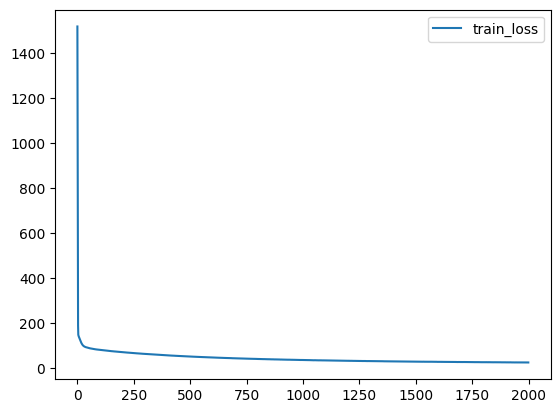

In [19]:
from matplotlib import pyplot as plt
plt.plot(losses, label='train_loss')

plt.legend()
plt.show

In [20]:
# pred_label = []
# true_label = []
# for batch in tqdm(testloader):
#     batch = [i.cuda() for i in batch]
#     sent_id, masks, labels = batch

#     preds = model(sent_id, masks)
#     #pred_label.extend(torch.argmax(preds, axis = 1).cpu())
#     pred_label.extend(preds.cpu())
#     true_label.extend(labels.cpu())

In [21]:
#在上面的代码中，我们首先定义了两个空列表pred_label和true_label来存储
#模型的预测标签和真实标签。然后，我们遍历测试集并对每个批次进行预测
#。将预测值和真实值添加到相应的列表中后，我们可以使用
#sklearn库中的mean_absolute_error函数来计算MAE。
#最后，我们将MAE打印出来。
from sklearn.metrics import mean_absolute_error

# pred_label = []
# true_label = []
pred_label_1 = []
pred_label_2 = []
true_label_1 = []
true_label_2 = []
for batch in tqdm(testloader):
    batch = [i.cuda() for i in batch]
    sent_id, masks, labels = batch

    preds = model(sent_id, masks)
    # pred_label.extend(preds.detach().cpu().numpy())
    # true_label.extend(labels.detach().cpu().numpy())
    pred_label_1.extend(preds[:, 0].detach().cpu().numpy())
    pred_label_2.extend(preds[:, 1].detach().cpu().numpy())
    true_label_1.extend(labels[:, 0].detach().cpu().numpy())
    true_label_2.extend(labels[:, 1].detach().cpu().numpy())

# mae = mean_absolute_error(true_label, pred_label)
mae_1 = mean_absolute_error(true_label_1, pred_label_1)
mae_2 = mean_absolute_error(true_label_2, pred_label_2)

#print(f'MAE: {mae}')

print(f'MAE for Valence: {mae_1}')
print(f'MAE for Arousal: {mae_2}')
#Ckipall2000,MAE for Valence: 0.9184504151344299,MAE for Arousal: 1.0241398811340332


100%|██████████| 81/81 [00:05<00:00, 14.55it/s]

MAE for Valence: 0.9657433032989502
MAE for Arousal: 1.0646086931228638


In [22]:
# def predict_sentiment(sentence, model, tokenizer):
#     encoded_sent = tokenizer.encode_plus(
#         sentence,
#         truncation=True,
#         max_length=50,
#         add_special_tokens=True,
#         # pad_to_max_length=True,
#         padding='longest',
#         return_attention_mask=True,
#         return_tensors='pt'
#     )
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     input_ids = encoded_sent['input_ids'].to(device)
#     attention_mask = encoded_sent['attention_mask'].to(device)

#     with torch.no_grad():
#         output = model(input_ids, attention_mask)

#     return output.item()

def predict_sentiment(sentence, model, tokenizer):
    encoded_sent = tokenizer.encode_plus(
        sentence,
        truncation=True,
        max_length=50,
        add_special_tokens=True,
        padding='longest',
        return_attention_mask=True,
        return_tensors='pt'
    )
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device('cuda'if torch.cuda.is_available() else print("gpu error"))
    input_ids = encoded_sent['input_ids'].to(device)
    attention_mask = encoded_sent['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)

    return output.cpu().numpy()

In [23]:
sentence = "傻逼嗎?"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你害我輸了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "可惡，你害我放槍了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "就等你這張"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "不知道要出哪張"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你到底會不會打牌"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "難過"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你很討厭"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "你老是盯我的牌，讓我很不舒服。"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我放槍了，這場遊戲讓我很失望。"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "很不友善"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "太可惡了"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "讓我多想想呢"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我很高興"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "我高興到不行"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))
sentence = "生氣"
score = predict_sentiment(sentence, model, tokenizer)
print(sentence,score-(5,5))



傻逼嗎? [[-1.64034963 -0.50846434]]
你害我輸了 [[-0.31021214 -0.33112669]]
可惡，你害我放槍了 [[-2.13733864  1.04170513]]
就等你這張 [[ 0.00529194 -0.77001429]]
不知道要出哪張 [[-0.63236189 -1.6869638 ]]
你到底會不會打牌 [[-2.15975022  2.16951656]]
難過 [[-2.25732946  0.91828108]]
你很討厭 [[-2.87188315  2.42374468]]
你老是盯我的牌，讓我很不舒服。 [[-2.13223028  2.10163641]]
我放槍了，這場遊戲讓我很失望。 [[-0.95302439  2.20225954]]
很不友善 [[-2.92085934  0.2524085 ]]
太可惡了 [[-2.69239593  2.40101147]]
讓我多想想呢 [[0.49540138 0.5229311 ]]
我很高興 [[1.38616896 0.55081224]]
我高興到不行 [[0.63202524 3.59934616]]
生氣 [[-1.14880586  0.16692877]]


In [24]:
torch.save(model.state_dict(), '../DongModel/BaseAll2000Dummy')
model.load_state_dict(torch.load('../DongModel/BaseAll2000Dummy'))
model.eval()
sentence = "胡屁胡"
score = predict_sentiment(sentence, model, tokenizer)
print(score)

[[2.169039 5.886961]]
